* 后记：  
这一版做的相当屎，  
clean data和最初三个模型已经花了25h45min，  
而且反复rerun code，前后矛盾又要去确认哪里出错，  
没有力气在在屎坑里重来了，重写一个文档吧。    
.  

* 总结做的不好的点：  
    * 栏目名称，英文中文交替，切换输入法总时间加起来也许都相当可观了  
下一版需要一开始就统一为英文  
    * pre-mature optimize，明明有更加容易得到的variable，却一开始就花费大量时间去clean '招录单位全称‘
下一版先清洗最易得的几个var，先跑一个quick and dirty的首个模型再说
    * 【最严重的问题】忽略情景，分析目标应该是，知道除了面试、综合成绩之外所有var时预测一个人能否录用
这一版最初几个模型居然用所有变量（包括面试、综合成绩）来预测。。。  
人家如果知道这么多信息了还用得着用模型预测吗
    * 忽略情景2，竞争规则是，“报考同一个岗位的人，择综合成绩前N名录取”，N是岗位招录人数
所以，报考同一岗位的人当中的笔试分数差应该是一个重要变量  
.  
* 下一班：  
    * 一来就用最容易得的变量跑模型，  
    * 然后增加变量：报同一个岗位的人的分数差
    * 再跑模型，error analysis
    * 然后，也许先聚类在跑模型

In [2128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.set_option('display.max_rows', 500)

# Understand the 3 2017-related dataset

In [2129]:
non_str = pd.ExcelFile('2017_non_strength_test.xls')
non_str0 = non_str.parse(0)

In [2130]:
type(non_str0)

pandas.core.frame.DataFrame

In [2131]:
non_str0.shape

(6790, 8)

In [2132]:
sus_total = list(non_str0.iloc[:, 0])
sus_total

[101361501305,
 101012909012,
 101361506621,
 101361509313,
 101361505521,
 101361502415,
 101012902828,
 101012909214,
 101361503425,
 101361505201,
 101360327501,
 101360322803,
 101360312002,
 101310101323,
 101240103216,
 101360319712,
 101360300804,
 101010306313,
 101360315618,
 101360313503,
 101360301918,
 101360320625,
 101010307217,
 101210104326,
 101330102020,
 101360308314,
 101360322811,
 101320501406,
 101010302325,
 101220102514,
 101360320314,
 101360318112,
 101240101030,
 101010300923,
 101360326615,
 101240103103,
 101010302120,
 101010306417,
 101010303109,
 101360314328,
 101010306512,
 101360302525,
 101010300214,
 101240103228,
 101360320927,
 101010300413,
 101360323102,
 101010308601,
 101360315014,
 101220102329,
 101010305516,
 101220103402,
 101010307802,
 101010307727,
 101010305026,
 101010306712,
 101210103020,
 101220103923,
 101010500121,
 101010505306,
 101360313818,
 101360306128,
 101360305702,
 101360321630,
 101360311622,
 101360309625,
 101010500

In [2133]:
d_puer = pd.ExcelFile('2017_puer.xls')
puer2017 = d_puer.parse(0)
puer2017.shape

(491, 3)

In [2134]:
puer2017.head()

,2017年普洱市考试录用公务员资格复审人员名单,Unnamed: 1,Unnamed: 2
0,准考证号,是否为首批资格复审人员,选中A列→CTRL+F→输入准考证号→查找下一个
1,101270501119,是,CTRL+A→CTRL+F→输入准考证号→查找下一个
2,101310300206,是,NaN
3,101270508430,是,NaN
4,101270502510,是,NaN


In [2135]:
puer2017 = puer2017.iloc[1:, 0:2]

In [2136]:
sus_puer = list(puer2017.iloc[1:, 0])
sus_puer

['101310300206',
 '101270508430',
 '101270502510',
 '101270503027',
 '101270502014',
 '101360908921',
 '201360203624',
 '201360203210',
 '201360203318',
 '201270601327',
 '201270601518',
 '201270601117',
 '201270601110',
 '201360203013',
 '501270601812',
 '501270602012',
 '501270602208',
 '501270602307',
 '501270601801',
 '501270602513',
 '501270601807',
 '501270601924',
 '501270602323',
 '501270602109',
 '501270601817',
 '501270601701',
 '501270602107',
 '501270602203',
 '501270602401',
 '501270602201',
 '501270601706',
 '501270602319',
 '501270602211',
 '501270601916',
 '501270601811',
 '501270602210',
 '501270601823',
 '501270601806',
 '501270602422',
 '501270602511',
 '501270602407',
 '501270601802',
 '501270602017',
 '501270601930',
 '501270601814',
 '501270602230',
 '501270601723',
 '501270601922',
 '501270602007',
 '501270602209',
 '501270602026',
 '501270602027',
 '501270602004',
 '501270601725',
 '501270602126',
 '501270601904',
 '501270601704',
 '501270601919',
 '501270602318

In [2137]:
sus_puer = list(map(int, sus_puer))

In [2138]:
identical = 0
non_identical = 0

for ele in sus_puer:
    if ele in sus_total:
        identical += 1
    if ele not in sus_total:
        non_identical += 1

print(identical)
print(non_identical)

340
149


所以，在‘2017_puer.xls’中的489个准考证号中，
有340个出现在来源可疑的‘2017_non_strength_test.xls'中；
剩下的149个会不会在'2017_strengh_test.xls’中呢？

In [2139]:
stren = pd.ExcelFile('2017_strength_test.xls')
stren0 = stren.parse(0)
stren0.head()

,准考证号,岗位代码,笔试总成绩,笔试总成绩岗位排名,所报岗位招录计划裁减后招录人数,所报岗位笔试最低合格分数线,进入体能测评否,是否为首批资格复审人员
0,101361501305,10100001001,148.5,1,1,105,--,是
1,101012909012,10100001001,146.5,2,1,105,--,是
2,101361506621,10100001002,162.5,1,1,105,--,是
3,101361509313,10100001002,162.0,2,1,105,--,是
4,101361505521,10100001003,174.0,1,1,105,--,是


In [2140]:
stren0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6790 entries, 0 to 6789
Data columns (total 8 columns):
准考证号               6790 non-null int64
岗位代码               6790 non-null int64
笔试总成绩              6790 non-null float64
笔试总成绩岗位排名          6790 non-null int64
所报岗位招录计划裁减后招录人数    6790 non-null int64
所报岗位笔试最低合格分数线      6790 non-null int64
进入体能测评否            6790 non-null object
是否为首批资格复审人员        6790 non-null object
dtypes: float64(1), int64(5), object(2)
memory usage: 424.5+ KB


乌龙了。
这两个文件似乎是一样的。都是不需要体测直接进入到资格复审的人群。
因为普洱文件没有笔试成绩，只能把能找到笔试成绩的340人作为预测目标了。

In [2141]:
puer2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 1 to 490
Data columns (total 2 columns):
2017年普洱市考试录用公务员资格复审人员名单    490 non-null object
Unnamed: 1                 490 non-null object
dtypes: object(2)
memory usage: 7.7+ KB


In [2142]:
non_str0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6790 entries, 0 to 6789
Data columns (total 8 columns):
准考证号               6790 non-null int64
岗位代码               6790 non-null int64
笔试总成绩              6790 non-null float64
笔试总成绩岗位排名          6790 non-null int64
所报岗位招录计划裁减后招录人数    6790 non-null int64
所报岗位笔试最低合格分数线      6790 non-null int64
进入体能测评否            6790 non-null object
是否为首批资格复审人员        6790 non-null object
dtypes: float64(1), int64(5), object(2)
memory usage: 424.5+ KB


In [2143]:
puer2017['2017年普洱市考试录用公务员资格复审人员名单'] = puer2017['2017年普洱市考试录用公务员资格复审人员名单'].astype('int64')

In [2144]:
p2017partial = pd.merge(puer2017, non_str0, 
                  left_on='2017年普洱市考试录用公务员资格复审人员名单', 
                  right_on = '准考证号',
                  how='inner')

In [2145]:
p2017partial.columns

Index(['2017年普洱市考试录用公务员资格复审人员名单', 'Unnamed: 1', '准考证号', '岗位代码', '笔试总成绩',
       '笔试总成绩岗位排名', '所报岗位招录计划裁减后招录人数', '所报岗位笔试最低合格分数线', '进入体能测评否',
       '是否为首批资格复审人员'],
      dtype='object')

In [2146]:
p2017partial = p2017partial[['准考证号', '岗位代码', '笔试总成绩','笔试总成绩岗位排名', '所报岗位招录计划裁减后招录人数']]
p2017partial

,准考证号,岗位代码,笔试总成绩,笔试总成绩岗位排名,所报岗位招录计划裁减后招录人数
0,101270501119,10829016001,140.5,2,1
1,101310300206,10829017001,150.5,1,1
2,101270508430,10829017001,148.0,2,1
3,101270502510,10829018001,148.0,1,1
4,101270503027,10829018001,146.5,2,1
5,101270502014,10829019001,151.5,1,1
6,101360908921,10829019001,144.0,2,1
7,101013001310,10800001001,158.5,1,1
8,101270510525,10800001001,143.5,2,1
9,101361602217,10800001002,154.5,1,1


现在2017年大众能查到笔试成绩的、并且进入面试的考生信息全部在上面了。  
需要和2017招考公告merge一下来得到岗位信息。

# Load and clean data from 2013-2016 (inclusive)

In [2147]:
# load 其它数据
files = ['2013.xls', '2014.xls', '2015.xls', '2016.xls']

data = {}

for f in files:
    ex = pd.ExcelFile(f)
    df = ex.parse(0)
    data[f.replace('.xls', '')] = df
    
data.keys()

dict_keys(['2016', '2014', '2015', '2013'])

## Clear header rows

In [2148]:
data['2013'].head(3)

,2013年普洱市考试录用公务员拟录用人员名单,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,面试时间→2013年·面试地点→中共普洱市委党校·综合成绩 =（笔试总成绩／3 + ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招考单位,招考人数,...,岗位 排名,是否进入体检（体测）,是否体检（体测）合格,是否进入考察,是否考察合格,是否录用,面试 考场,面试 轮次,抽签 顺序号,考生具体 面试时间


In [2149]:
data['2014'].head(3)

,2014年普洱市考试录用公务员拟录用人员名单,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,面试时间→2014年·面试地点→中共普洱市委党校·综合成绩 =（笔试总成绩／3 + ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招录单位全称,招考人数,...,面试 成绩,综合 成绩,岗位 排名,是否进体测体检考察,是否考察合格,是否录用,面试考场,面试轮次,抽签 顺序号,考生具体 面试时间


In [2150]:
data['2015'].head(3)

,2015年普洱市考试录用公务员拟录用人员名单,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,面试地点·中共普洱市委党校,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,分组,组合,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,...,其他 测试,综合 成绩,招考 岗位 排名,是否进入体检体测,是否进入考察,最终是否录用,抽签考场号码,抽签轮次号码,抽签 胸牌 号码,考生具体 面试时间
2,第6组,组合1,11240900520,杨瑞琳,女,汉族,对外经济贸易大学,大学本科,学士,0800001001,...,NaN,74.8,1,是,是,是,12,1,P105,2015年8月22日上午


In [2151]:
data['2016'].head(3)

,2016年普洱市考试录用公务员综合成绩公告,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,面试地点·中共普洱市委党校,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,分组,组合,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,...,综合 成绩,招考 岗位 排名,是否进入体检,是否进入考察,最终是否录用,抽签考场号码,抽签轮次号码,抽签 胸牌 号码,抽签考生确认签名,考生具体 面试时间
2,第1组,组合1,101270301011,黄梅,女,汉族,楚雄师范学院,大学专科,无学位,10825007001,...,68.61,1,是,NaN,NaN,7,1,G103,NaN,2016年7月17日上午


In [2152]:
def pull_up_rows(df, numRow):
    df.columns = df.iloc[numRow - 1, :]
    df = df[numRow:]
    return df

In [2153]:
for year in ['2013', '2014']:
    data[year] = pull_up_rows(data[year], 3)
for year in ['2015', '2016']:
    data[year] = pull_up_rows(data[year], 2)

In [2154]:
for key, val in data.items():
    print(key + ':\n')
    print(val.head(3))

2016:

1   分组  组合           准考证号   姓名 性别  民族      毕业院校    学历   学位         岗位代码  \
2  第1组  组合1  101270301011   黄梅  女  汉族    楚雄师范学院  大学专科  无学位  10825007001   
3  第1组  组合1  101270101212  王明贤  男  汉族      西南大学  大学专科  无学位  10825007001   
4  第1组  组合1  101011602626   罗杰  男  彝族  辽宁工程技术大学  大学本科  双学士  10824010001   

1        ...        综合     成绩 招考   岗位         排名 是否进入体检 是否进入考察 最终是否录用 抽签考场号码  \
2        ...            68.61                  1      是    NaN    NaN      7   
3        ...            64.91                  2      否    NaN    NaN      7   
4        ...            67.42                  2      否    NaN    NaN      7   

1 抽签轮次号码 抽签  胸牌  号码 抽签考生确认签名 考生具体         面试时间  
2      1       G103      NaN      2016年7月17日上午  
3      1       G104      NaN      2016年7月17日上午  
4      1       G102      NaN      2016年7月17日上午  

[3 rows x 25 columns]
2014:

2         准考证号   姓名 性别  民族          毕业院校    学历   学位        岗位代码  \
3  11360801914   姚梅  女  彝族  云南国防工业职业技术学院  大学专科  无学位  0821001001   
4  11360202

Header rows cleared.

## Select columns

In [2155]:
for year in data.keys():
    print(year + ':\n')
    print(data[year].columns)

2016:

Index(['分组', '组合 ', '准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码',
       '招录单位全称', '招考人数', '笔试\n总成绩', '面试       总成绩', '经历业绩评价', '综合     成绩',
       '招考   岗位         排名', '是否进入体检', '是否进入考察', '最终是否录用', '抽签考场号码', '抽签轮次号码',
       '抽签  胸牌  号码', '抽签考生确认签名', '考生具体         面试时间'],
      dtype='object', name=1)
2014:

Index(['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码', '招录单位全称', '招考人数',
       '笔试\n成绩', '面试       成绩', '综合     成绩', '岗位         排名', '是否进体测体检考察',
       '是否考察合格', '是否录用', '面试考场', '面试轮次', '抽签         顺序号',
       '考生具体         面试时间'],
      dtype='object', name=2)
2015:

Index(['分组', '组合 ', '准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码',
       '招录单位全称', '招考人数', '笔试\n成绩', '面试       成绩', '其他         测试', '综合     成绩',
       '招考   岗位         排名', '是否进入体检体测', '是否进入考察', '最终是否录用', '抽签考场号码',
       '抽签轮次号码', '抽签  胸牌  号码', '考生具体         面试时间'],
      dtype='object', name=1)
2013:

Index(['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码', '招考单位', '招考人数',
  

In [2156]:
# 注意到2016年有个'经历业绩评价'，好像不太对
data['2016'].head(10).iloc[:, 7:]

1,学历,学位,岗位代码,招录单位全称,招考人数,笔试 总成绩,面试 总成绩,经历业绩评价,综合 成绩,招考 岗位 排名,是否进入体检,是否进入考察,最终是否录用,抽签考场号码,抽签轮次号码,抽签 胸牌 号码,抽签考生确认签名,考生具体 面试时间
2,大学专科,无学位,10825007001,镇沅彝族哈尼族拉祜族自治县者东镇财政所,1,54.33,82.89,NaN,68.61,1,是,NaN,NaN,7,1,G103,NaN,2016年7月17日上午
3,大学专科,无学位,10825007001,镇沅彝族哈尼族拉祜族自治县者东镇财政所,1,50.67,79.15,NaN,64.91,2,否,NaN,NaN,7,1,G104,NaN,2016年7月17日上午
4,大学本科,双学士,10824010001,景谷傣族彝族自治县半坡乡人民政府,1,52.5,82.33,NaN,67.42,2,否,NaN,NaN,7,1,G102,NaN,2016年7月17日上午
5,大学本科,学士,10824010001,景谷傣族彝族自治县半坡乡人民政府,1,52.5,82.86,NaN,67.68,1,是,NaN,NaN,7,1,G101,NaN,2016年7月17日上午
6,大学本科,学士,40824026001,普洱市景谷傣族彝族自治县公安局益智派出所,1,46,79.45,NaN,62.73,1,是,NaN,NaN,7,1,G105,NaN,2016年7月17日上午
7,大学本科,学士,10800005001,思茅区社会保险局,1,56.17,81.29,NaN,68.73,1,是,NaN,NaN,7,2,G201,NaN,2016年7月17日上午
8,大学本科,学士,10800005001,思茅区社会保险局,1,50.17,79.28,NaN,64.73,2,否,NaN,NaN,7,2,G203,NaN,2016年7月17日上午
9,大学本科,学士,10826010001,普洱市江城县地方税务局,1,53.33,83.15,NaN,68.24,1,是,NaN,NaN,7,2,G206,NaN,2016年7月17日上午
10,大学本科,学士,10826010001,普洱市江城县地方税务局,1,50,76.21,NaN,63.11,2,否,NaN,NaN,7,2,G202,NaN,2016年7月17日上午
11,大学本科,学士,10825006001,普洱市道路运输管理局镇沅县道路运输管理所,1,62.67,81.88,NaN,72.28,1,是,NaN,NaN,7,2,G204,NaN,2016年7月17日上午


查看原文件后发现'经历业绩评价’都是NaN.看似没问题了。

注意到另外两个问题：
* 其一
最终录用一栏也是NaN，数据源有问题。
重新查找后在中公教育的新浪博客找到了有“是否录用”的完整数据。
重新load吧。
* 其二
笔试满分相较于前面几年应该有变化，
应用learning algorithm时注意data normalization。

In [2157]:
data['2016'] = pd.ExcelFile('2016_def.xls').parse(0)
data['2016'].head()

,2016年普洱市考试录用公务员拟录用人员名单,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,面试地点·中共普洱市委党校,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,分组,组合,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,...,经历业绩评价,综合 成绩,岗位 排名,是否进入体检考察,体检考察是否合格,最终是否录用,抽签考场号码,抽签轮次号码,抽签 胸牌 号码,考生具体 面试时间
2,第1组,组合1,101270301011,黄梅,女,汉族,楚雄师范学院,大学专科,无学位,10825007001,...,NaN,68.61,1,是,是,是,7,1,G103,2016年7月17日上午
3,第1组,组合1,101361201318,付强,男,彝族,云南民族大学,大学本科,学士,10824010001,...,NaN,67.68,1,是,是,是,7,1,G101,2016年7月17日上午
4,第1组,组合1,401270105202,朱荣涛,男,汉族,云南农业大学,大学本科,学士,40824026001,...,NaN,62.73,1,是,是,是,7,1,G105,2016年7月17日上午


In [2158]:
data['2016'] = pull_up_rows(data['2016'], 2)
data['2016'].head()

1,分组,组合,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,...,经历业绩评价,综合 成绩,岗位 排名,是否进入体检考察,体检考察是否合格,最终是否录用,抽签考场号码,抽签轮次号码,抽签 胸牌 号码,考生具体 面试时间
2,第1组,组合1,101270301011,黄梅,女,汉族,楚雄师范学院,大学专科,无学位,10825007001,...,NaN,68.61,1,是,是,是,7,1,G103,2016年7月17日上午
3,第1组,组合1,101361201318,付强,男,彝族,云南民族大学,大学本科,学士,10824010001,...,NaN,67.68,1,是,是,是,7,1,G101,2016年7月17日上午
4,第1组,组合1,401270105202,朱荣涛,男,汉族,云南农业大学,大学本科,学士,40824026001,...,NaN,62.73,1,是,是,是,7,1,G105,2016年7月17日上午
5,第1组,组合2,101270103330,赵铭德,男,汉族,云南民族大学,大学本科,学士,10800005001,...,NaN,68.73,1,是,是,是,7,2,G201,2016年7月17日上午
6,第1组,组合2,101360207008,杨丽波,女,汉族,云南师范大学,大学本科,学士,10825006001,...,NaN,72.28,1,是,是,是,7,2,G204,2016年7月17日上午


In [2159]:
# 每个表都slightly diff，只好手动
data['2016'] = data['2016'][['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码',
       '招录单位全称', '招考人数','笔试\n总成绩', '面试       成绩','综合     成绩',
       '岗位         排名', '最终是否录用']]

data['2014'] = data['2014'][['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码', '招录单位全称', '招考人数',
       '笔试\n成绩', '面试       成绩', '综合     成绩', '岗位         排名','是否录用']]

data['2013'] = data['2013'][['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码', '招考单位', '招考人数',
       '笔试        成绩', '面试       成绩', '综合     成绩', '岗位         排名','是否录用']]

data['2015'] = data['2015'][['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码',
       '招录单位全称', '招考人数', '笔试\n成绩', '面试       成绩','综合     成绩',
       '招考   岗位         排名','最终是否录用', ]]

In [2160]:
for year in data.keys():
    print(year + ':\n')
    print(data[year].columns)

2016:

Index(['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码', '招录单位全称', '招考人数',
       '笔试\n总成绩', '面试       成绩', '综合     成绩', '岗位         排名', '最终是否录用'],
      dtype='object', name=1)
2014:

Index(['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码', '招录单位全称', '招考人数',
       '笔试\n成绩', '面试       成绩', '综合     成绩', '岗位         排名', '是否录用'],
      dtype='object', name=2)
2015:

Index(['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码', '招录单位全称', '招考人数',
       '笔试\n成绩', '面试       成绩', '综合     成绩', '招考   岗位         排名', '最终是否录用'],
      dtype='object', name=1)
2013:

Index(['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', '岗位代码', '招考单位', '招考人数',
       '笔试        成绩', '面试       成绩', '综合     成绩', '岗位         排名', '是否录用'],
      dtype='object', name=2)


In [2161]:
cols = ['准考证号', '姓名', '性别', '民族', '毕业院校', '学历', '学位', 
 '岗位代码', '招录单位全称', '招考人数', 
 '笔试', '面试', '综合成绩', '招考岗位排名', '是否录用']

for year in data.keys():
    data[year].columns = cols

现在所有df都去掉了不必要的col，保留的col都改了相同的名字。

## clean data

### concat dataframes

In [2162]:
# 每个df里加一栏年份，准备concat
for year in range(2013, 2017):
    data[str(year)].loc[:,'年份'] = str(year)

/Users/EzraYang/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/EzraYang/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [2163]:
df = pd.concat([data['2013'], data['2014'], data['2015'], data['2016']], 
              ignore_index=True)

In [2164]:
df.head()
df.tail()

,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招录单位全称,招考人数,笔试,面试,综合成绩,招考岗位排名,是否录用,年份
2300,101270300118,吕斌,男,汉族,桂林电子科技大学,大学本科,学士,533600009003,普洱市,5,54.33,86,69.57,5,是,2016
2301,101270301316,张秋芳,女,汉族,云南师范大学,大学本科,学士,533600009004,普洱市,4,60.83,82.22,71.5,2,是,2016
2302,101270401102,王悦,女,彝族,云南民族大学,大学本科,学士,533600009004,普洱市,4,59,85.79,71.53,1,是,2016
2303,101300404017,尹加雪,女,汉族,昆明学院,大学本科,学士,533600009004,普洱市,4,57.33,85.45,70.58,3,是,2016
2304,101270402211,曹梦娇,女,拉祜族,云南民族大学,大学本科,学士,533600009004,普洱市,4,55.5,85.21,69.87,4,是,2016


In [2165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2305 entries, 0 to 2304
Data columns (total 16 columns):
准考证号      2305 non-null object
姓名        2305 non-null object
性别        2289 non-null object
民族        2289 non-null object
毕业院校      2183 non-null object
学历        2228 non-null object
学位        2183 non-null object
岗位代码      2305 non-null object
招录单位全称    2305 non-null object
招考人数      1761 non-null object
笔试        2305 non-null object
面试        2305 non-null object
综合成绩      2305 non-null object
招考岗位排名    2305 non-null object
是否录用      2305 non-null object
年份        2305 non-null object
dtypes: object(16)
memory usage: 288.2+ KB


### normalize scores by year

In [2166]:
df['笔试'] = df['笔试'].astype(float)
df['面试'] = df['面试'].astype(float)
df['综合成绩'] = df['综合成绩'].astype(float)

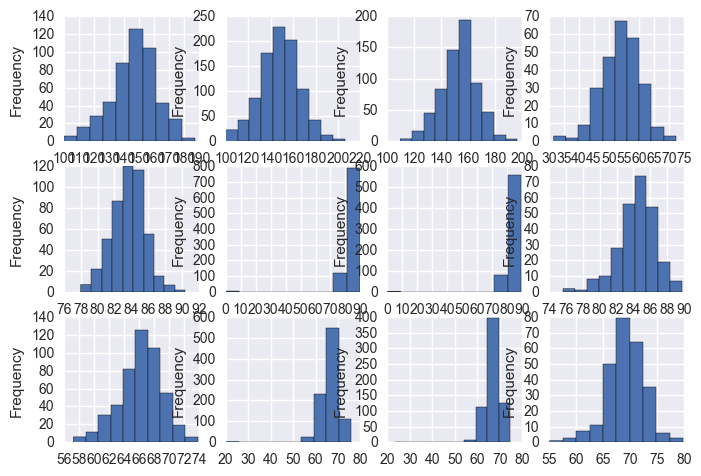

In [2167]:
# plot to see score distribution
    # first row
plt.subplot(3,4,1)
df.loc[df['年份']=='2013','笔试'].plot(kind='hist')
plt.subplot(3,4,2)
df.loc[df['年份']=='2014','笔试'].plot(kind='hist')
plt.subplot(3,4,3)
df.loc[df['年份']=='2015','笔试'].plot(kind='hist')
plt.subplot(3,4,4)
df.loc[df['年份']=='2016','笔试'].plot(kind='hist')
    # 2nd row 
plt.subplot(3,4,5)
df.loc[df['年份']=='2013','面试'].plot(kind='hist')
plt.subplot(3,4,6)
df.loc[df['年份']=='2014','面试'].plot(kind='hist')
plt.subplot(3,4,7)
df.loc[df['年份']=='2015','面试'].plot(kind='hist')
plt.subplot(3,4,8)
df.loc[df['年份']=='2016','面试'].plot(kind='hist')
    # 3rd row 
plt.subplot(3,4,9)
df.loc[df['年份']=='2013','综合成绩'].plot(kind='hist')
plt.subplot(3,4,10)
df.loc[df['年份']=='2014','综合成绩'].plot(kind='hist')
plt.subplot(3,4,11)
df.loc[df['年份']=='2015','综合成绩'].plot(kind='hist')
plt.subplot(3,4,12)
df.loc[df['年份']=='2016','综合成绩'].plot(kind='hist')

看起来2014,2015年的面试成绩和综合成绩都有少量低分。如果是0分，should be encoded as NaN.

In [2168]:
df.loc[df['年份']=='2014','面试'].sort_values().head(10)

1003     0.00
1079     0.00
1139     0.00
826      0.00
739      0.00
959     73.68
1029    76.07
1390    76.21
953     76.44
844     76.59
Name: 面试, dtype: float64

In [2169]:
df.loc[df['年份']=='2015','面试'].sort_values().head(5) # by default ascending, 
                                                       # see the 5 lowest scores

2045     0.00
2044    72.46
2026    73.42
2030    73.48
2003    74.00
Name: 面试, dtype: float64

In [2170]:
df.loc[df['年份']=='2014','综合成绩'].sort_values().head(7)

1079    20.33
826     21.33
739     21.42
1003    22.58
1139    28.58
1029    54.70
1176    55.52
Name: 综合成绩, dtype: float64

In [2171]:
df.loc[df['年份']=='2015','综合成绩'].sort_values().head(7)

2045    23.50
2044    56.40
2043    57.91
2042    58.06
2041    59.16
2040    59.19
2039    59.33
Name: 综合成绩, dtype: float64

In [2172]:
# 经对比index，就是这几个没有参加面试的人综合成绩在far left
# 把这几行drop掉
df = df.drop([1003,1079,1139,826,739,2045])

In [2173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2304
Data columns (total 16 columns):
准考证号      2299 non-null object
姓名        2299 non-null object
性别        2283 non-null object
民族        2283 non-null object
毕业院校      2179 non-null object
学历        2222 non-null object
学位        2179 non-null object
岗位代码      2299 non-null object
招录单位全称    2299 non-null object
招考人数      1759 non-null object
笔试        2299 non-null float64
面试        2299 non-null float64
综合成绩      2299 non-null float64
招考岗位排名    2299 non-null object
是否录用      2299 non-null object
年份        2299 non-null object
dtypes: float64(3), object(13)
memory usage: 305.3+ KB


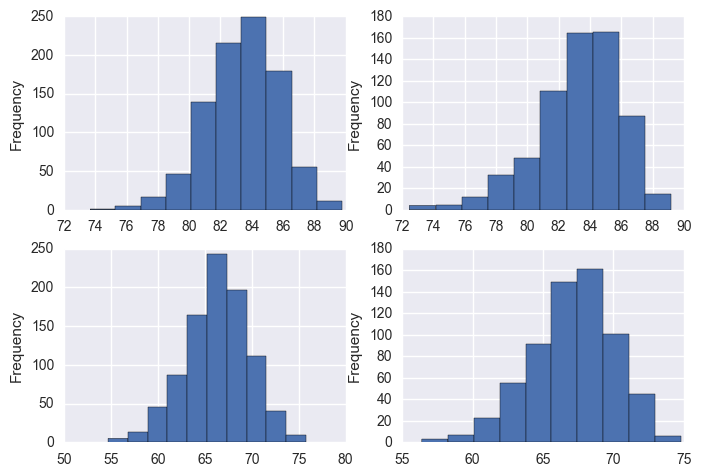

In [2174]:
# plot to see score distribution
    # 2nd row 
plt.subplot(2,2,1)
df.loc[df['年份']=='2014','面试'].plot(kind='hist')
plt.subplot(2,2,2)
df.loc[df['年份']=='2015','面试'].plot(kind='hist')
    # 3rd row 
plt.subplot(2,2,3)
df.loc[df['年份']=='2014','综合成绩'].plot(kind='hist')
plt.subplot(2,2,4)
df.loc[df['年份']=='2015','综合成绩'].plot(kind='hist')

ready to model each plot with gausian distribute.

In [2175]:
# normalize scores by year

df.groupby('年份')[['笔试','面试','综合成绩']].mean()

,笔试,面试,综合成绩
年份,,,
2013,146.703934,83.645590,66.274348
2014,148.121507,83.419334,66.397445
2015,153.035881,83.309563,67.113011
2016,53.921081,84.399112,69.145135


In [2176]:
def normalize_series(series):
    return (series-series.mean()) / (series.std())

In [2177]:
df['exam'] = df.groupby('年份')['笔试'].transform(normalize_series)
df['interview'] = df.groupby('年份')['面试'].transform(normalize_series)
df['score'] = df.groupby('年份')['综合成绩'].transform(normalize_series)

In [2178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2304
Data columns (total 19 columns):
准考证号         2299 non-null object
姓名           2299 non-null object
性别           2283 non-null object
民族           2283 non-null object
毕业院校         2179 non-null object
学历           2222 non-null object
学位           2179 non-null object
岗位代码         2299 non-null object
招录单位全称       2299 non-null object
招考人数         1759 non-null object
笔试           2299 non-null float64
面试           2299 non-null float64
综合成绩         2299 non-null float64
招考岗位排名       2299 non-null object
是否录用         2299 non-null object
年份           2299 non-null object
exam         2299 non-null float64
interview    2299 non-null float64
score        2299 non-null float64
dtypes: float64(6), object(13)
memory usage: 359.2+ KB


In [2179]:
# round up z-scores to 2 decimals
df['exam'] = df['exam'].round(2)
df['interview'] = df['interview'].round(2)
df['score'] = df['score'].round(2)

In [2180]:
df.groupby('年份')[['exam','interview','score']].mean()  # expect all close to 0

,exam,interview,score
年份,,,
2013,-2.919220e-17,2.070393e-05,-0.000041
2014,-4.366812e-05,1.963495e-17,-0.000164
2015,1.092044e-04,-1.560062e-04,-0.000203
2016,1.930502e-04,-2.702703e-04,0.000193


### re-code ’是否录用‘

In [2181]:
# re-encode ’是否录用'
df['是否录用'].value_counts()

是     1037
否      779
录用     483
Name: 是否录用, dtype: int64

In [2182]:
def recode_accep(accep):
    if accep == '是':
        return '1'
    elif accep == '否':
        return '0'
    elif accep == '录用':
        return '1'
    else:
        return np.nan

In [2183]:
df['accep'] = df['是否录用'].apply(recode_accep)

In [2184]:
df['accep'] = df['accep'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2304
Data columns (total 20 columns):
准考证号         2299 non-null object
姓名           2299 non-null object
性别           2283 non-null object
民族           2283 non-null object
毕业院校         2179 non-null object
学历           2222 non-null object
学位           2179 non-null object
岗位代码         2299 non-null object
招录单位全称       2299 non-null object
招考人数         1759 non-null object
笔试           2299 non-null float64
面试           2299 non-null float64
综合成绩         2299 non-null float64
招考岗位排名       2299 non-null object
是否录用         2299 non-null object
年份           2299 non-null object
exam         2299 non-null float64
interview    2299 non-null float64
score        2299 non-null float64
accep        2299 non-null int64
dtypes: float64(6), int64(1), object(13)
memory usage: 377.2+ KB


### clean ‘招录单位全称’

In [2185]:
df['招录单位全称'].value_counts()

普洱市                                  60
孟连县公安局                               56
澜沧拉祜族自治县乡镇人民政府                       44
墨江县乡镇党政办公室                           31
墨江县乡镇人民政府机关                          28
墨江县乡镇社会事务办公室                         22
宁洱哈尼族彝族自治县黎明乡人民政府                    22
宁洱哈尼族彝族自治县德安乡人民政府                    18
普洱市公安局                               18
景东彝族自治县乡镇人民政府                        18
墨江县乡镇财政所                             16
景谷傣族彝族自治县勐班乡人民政府                     16
孟连县富岩镇人民政府                           15
普洱市景谷县地方税务局                          15
澜沧县乡镇人民政府                            15
江城哈尼族彝族自治县公安局                        15
普洱市公安局交通警察支队磨思高速公路交巡警大队（思茅区）         15
景谷傣族彝族自治县益智乡人民政府                     14
普洱市景东县地方税务局                          13
宁洱哈尼族彝族自治县同心镇人民政府                    13
江城县勐烈镇人民政府                           13
宁洱哈尼族彝族自治县磨黑镇人民政府                    12
江城县国庆乡人民政府                           12
孟连县芒信镇人民政府                           12
景谷傣族彝族自治县正兴镇人民政府                     12


发现三个问题：
* 每个县有两种写法。。‘XX县’和‘XXXXXXX族自治县’应该统一格式 -- done
* 普洱市是什么鬼，有没有单独的XX区，XX县？这些岗位是干嘛的，为什么都不说清楚
* ‘中共’ & ‘中国共产党’应该统一格式(minor)

#### 统一县名，省掉民族自治

In [2186]:
# sanity check: at the end,
# will sum(dict.values()) the same number as total(2305)?

district_full = {'普洱市':0, '思茅区':0, '宁洱哈尼族彝族自治县':0, 
                 '墨江哈尼族自治县':0, '景东彝族自治县':0, 
                 '景谷傣族彝族自治县':0, '镇沅彝族哈尼族拉祜族自治县':0, 
                 '江城哈尼族彝族自治县':0,'孟连傣族拉祜族佤族自治县':0, 
                 '澜沧拉祜族自治县':0, '西盟佤族自治县':0}

district = {'普洱市':0,'思茅区':0,'宁洱县':0,'墨江县':0,'景东县':0,'景谷县':0,
            '镇沅县':0,'江城县':0,'孟连县':0,'澜沧县':0,'西盟县':0}

simultaneously set dictionary values to be 0, see [here](https://stackoverflow.com/questions/13712229/simultaneously-replacing-all-values-of-a-dictionary-to-zero-python)

In [2187]:
def county_name_count(string, district_dict):
    for key in district_dict.keys():
        if key in string:
            district_dict[key] += 1

In [2188]:
df['招录单位全称'].apply(county_name_count, args =(district_full,) )

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
30      None
31      None
32      None
33      None
34      None
35      None
36      None
37      None
38      None
39      None
40      None
41      None
42      None
43      None
44      None
45      None
46      None
47      None
48      None
49      None
50      None
51      None
52      None
53      None
54      None
55      None
56      None
57      None
58      None
59      None
60      None
61      None
62      None
63      None
64      None
65      None
66      None
67      None
68      None
69      None
70      None
71      None
72      None
73      None
74      None
75      None
76      None

pd.Series.apply(func)中的func可以接受除了Series之外的其它argument，
详情见这：
[stackoverflow](https://stackoverflow.com/questions/12182744/python-pandas-apply-a-function-with-arguments-to-a-series), 
[doc](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.apply.html#pandas.Series.apply)

In [2189]:
district_full

{'墨江哈尼族自治县': 1,
 '孟连傣族拉祜族佤族自治县': 1,
 '宁洱哈尼族彝族自治县': 200,
 '思茅区': 138,
 '普洱市': 441,
 '景东彝族自治县': 178,
 '景谷傣族彝族自治县': 210,
 '江城哈尼族彝族自治县': 98,
 '澜沧拉祜族自治县': 101,
 '西盟佤族自治县': 112,
 '镇沅彝族哈尼族拉祜族自治县': 99}

In [2190]:
df['招录单位全称'].apply(county_name_count, args =(district,) )

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
30      None
31      None
32      None
33      None
34      None
35      None
36      None
37      None
38      None
39      None
40      None
41      None
42      None
43      None
44      None
45      None
46      None
47      None
48      None
49      None
50      None
51      None
52      None
53      None
54      None
55      None
56      None
57      None
58      None
59      None
60      None
61      None
62      None
63      None
64      None
65      None
66      None
67      None
68      None
69      None
70      None
71      None
72      None
73      None
74      None
75      None
76      None

In [2191]:
district

{'墨江县': 310,
 '孟连县': 187,
 '宁洱县': 35,
 '思茅区': 138,
 '普洱市': 441,
 '景东县': 24,
 '景谷县': 42,
 '江城县': 132,
 '澜沧县': 123,
 '西盟县': 93,
 '镇沅县': 77}

In [2192]:
sum(district_full.values()) + sum(district.values()) - 138 - 442

2601

尼玛，这sanity check是挖坑给自己跳吗，
希望得到2305(totol obs.),结果谜之多出来300多个。。。
不管了先替换了再算总数。

In [2193]:
# 统一每个县的名称
def recode_county(name):
    return name.replace('宁洱哈尼族彝族自治县',
                        '宁洱县').replace('墨江哈尼族自治县', 
                        '墨江县').replace('景东彝族自治县',
                        '景东县').replace('景谷傣族彝族自治县',
                        '景谷县').replace('镇沅彝族哈尼族拉祜族自治县', 
                        '镇沅县').replace('江城哈尼族彝族自治县',
                        '江城县').replace('孟连傣族拉祜族佤族自治县',
                        '孟连县').replace('澜沧拉祜族自治县',
                        '澜沧县').replace('西盟佤族自治县',  
                        '西盟县')
    

In [2194]:
df['招录单位全称'] = df['招录单位全称'].apply(recode_county)

In [2195]:
df['招录单位全称']

0                        普洱市公安局
1                      普洱市劳动就业局
2                    普洱市劳动社会保险局
3                  普洱市人民政府金融办公室
4                  普洱市人民政府金融办公室
5                   普洱市卫生局卫生监督局
6                   普洱市卫生局卫生监督局
7                    普洱市道路运输管理局
8          普洱市道路运输管理局思茅区道路运输管理所
9          普洱市道路运输管理局思茅区道路运输管理所
10         普洱市道路运输管理局宁洱县道路运输管理所
11         普洱市道路运输管理局宁洱县道路运输管理所
12         普洱市道路运输管理局孟连县道路运输管理所
13                       思茅区财政局
14                       思茅区财政局
15                       思茅区档案局
16                       思茅区档案局
17                       思茅区教育局
18                       思茅区教育局
19                  思茅区劳动保障监察大队
20                  思茅区劳动保障监察大队
21                  思茅区劳动保障监察大队
22                  思茅区劳动保障监察大队
23                   思茅区六顺乡人民政府
24                    思茅区龙潭乡财政所
25               思茅区龙潭彝族傣族乡人民政府
26               思茅区龙潭彝族傣族乡人民政府
27                    思茅区南屏镇财政所
28                  思茅区思茅港镇人民政府
29                       思茅区卫生局
30                       思茅区卫生局
31      

现在，’XX族自治县‘已经改为’XX县‘

#### 使’招录单位全称’只含有市、县区其中之一

看到obs. 2285, '普洱市镇沅县公安局按板派出所'，是一个在乡镇的单位，可是全称包含上一级、上上级行政区划。
还有obs. 8-12， ‘普洱市道路运输管理局孟连县道路运输管理所’,市属单位真蛋疼。

现在知道全称 + 简称 - 重复计算的普洱市、思茅区 大于总行数的原因了，
因为同一个string里会含有多个行政区划名称。  

为了让每个招录单位全称的前三个字都具体到所在县区，还得再检查一遍一行中有两个地区名称（普洱市XX县）的情况，把普洱市去掉。

In [2196]:
def count_distr(string):
    count = 0
    for loc in ['普洱市', '思茅区', '宁洱县', '墨江县', '景东县', '景谷县', 
                '镇沅县', '江城县', '孟连县', '澜沧县', '西盟县']:
        if loc in string:
            count += 1
    return count

In [2197]:
loc_count = np.array([ df['招录单位全称'].apply(count_distr) ])
loc_count

array([[1, 1, 1, ..., 1, 1, 1]])

In [2198]:
for i in range(0, 3):
    print(len(df['招录单位全称'][(loc_count == i)[0]]))

7
1982
310


In [2199]:
# mis-typing
df['招录单位全称'][(loc_count == 0)[0]]

338            孟连富岩乡人民政府
482          中共西盟自治县委组织部
486        景东彝族自治且龙街乡财政所
487        景东彝族自治且龙街乡财政所
488        景东彝族自治且龙街乡财政所
489        景东彝族自治且龙街乡财政所
2097    宁洱哈尼组彝族自治县普义乡财政所
Name: 招录单位全称, dtype: object

In [2200]:
# correct mis-typing
list(df.columns).index('招录单位全称')

8

In [2201]:
# correct mis-typing
df.iloc[338,8]

'孟连富岩乡人民政府'

In [2202]:
# correct mis-typing
df.iloc[338,8] = '孟连县富岩乡人民政府'
df.iloc[482,8] = '中共西盟县委组织部'
df.iloc[486,8] = '景东县龙街乡财政所'
df.iloc[487,8] = '景东县龙街乡财政所'
df.iloc[488,8] = '景东县龙街乡财政所'
df.iloc[489,8] = '景东县龙街乡财政所'
df.iloc[2097,8] = '宁洱县普义乡财政所'

In [2203]:
# ideal
df['招录单位全称'][(loc_count == 1)[0]]

0                     普洱市公安局
1                   普洱市劳动就业局
2                 普洱市劳动社会保险局
3               普洱市人民政府金融办公室
4               普洱市人民政府金融办公室
5                普洱市卫生局卫生监督局
6                普洱市卫生局卫生监督局
7                 普洱市道路运输管理局
13                    思茅区财政局
14                    思茅区财政局
15                    思茅区档案局
16                    思茅区档案局
17                    思茅区教育局
18                    思茅区教育局
19               思茅区劳动保障监察大队
20               思茅区劳动保障监察大队
21               思茅区劳动保障监察大队
22               思茅区劳动保障监察大队
23                思茅区六顺乡人民政府
24                 思茅区龙潭乡财政所
25            思茅区龙潭彝族傣族乡人民政府
26            思茅区龙潭彝族傣族乡人民政府
27                 思茅区南屏镇财政所
28               思茅区思茅港镇人民政府
29                    思茅区卫生局
30                    思茅区卫生局
31             思茅区医疗保险基金管理中心
32             思茅区医疗保险基金管理中心
33                 思茅区倚象镇财政所
34                思茅区倚象镇人民政府
35                思茅区云仙乡人民政府
36                思茅区云仙乡人民政府
37                    宁洱县档案局
38                宁洱县德安乡人民政府
39            

In [2204]:
# '普洱市XXX区/县' issue
df['招录单位全称'][(loc_count == 2)[0]]

8               普洱市道路运输管理局思茅区道路运输管理所
9               普洱市道路运输管理局思茅区道路运输管理所
10              普洱市道路运输管理局宁洱县道路运输管理所
11              普洱市道路运输管理局宁洱县道路运输管理所
12              普洱市道路运输管理局孟连县道路运输管理所
405                    普洱市西盟县岳宋乡人民政府
406                    普洱市西盟县岳宋乡人民政府
440                    普洱市思茅区工商行政管理局
441                    普洱市宁洱县工商行政管理局
442                    普洱市墨江县工商行政管理局
443                    普洱市江城县工商行政管理局
444                    普洱市澜沧县工商行政管理局
445                    普洱市澜沧县工商行政管理局
446                    普洱市孟连县工商行政管理局
447                    普洱市西盟县工商行政管理局
448                    普洱市西盟县工商行政管理局
449                      普洱市墨江县地方税务局
450                      普洱市景东县地方税务局
451                      普洱市景谷县地方税务局
452                      普洱市镇沅县地方税务局
453                      普洱市镇沅县地方税务局
454                      普洱市江城县地方税务局
455                      普洱市孟连县地方税务局
456                      普洱市孟连县地方税务局
457                      普洱市澜沧县地方税务局
458                      普洱市西盟县地方税务局
472                 中共普洱市思茅区委机构编制办公室
5

In [2205]:
loc_count2 = np.array([ df['招录单位全称'].apply(count_distr) ])
loc_count2
for i in range(0, 3):
    print(len(df['招录单位全称'][(loc_count2 == i)[0]]))

1
1988
310


In [2206]:
def clean_2_distr(string):
    string = string.replace('普洱市', '') # 市+区/县的，去掉'普洱市'
    if '县' in string:
        county = re.search('..县', string).group(0)
    elif '区' in string:
        county = re.search('..区', string).group(0)
    string = string.replace(county, '')
    string = county + string  # 把县/区名字挪到最先
    return string

In [2207]:
assert clean_2_distr('普洱市思茅区审计局') == '思茅区审计局'
assert clean_2_distr('普洱市道路运输管理局孟连县道路运输管理所') == '孟连县道路运输管理局道路运输管理所'
assert clean_2_distr('普洱市西盟县工商行政管理局') == '西盟县工商行政管理局'
assert clean_2_distr('普洱市公安局交通警察支队元磨高速公路交巡警大队（墨江县）') == '墨江县公安局交通警察支队元磨高速公路交巡警大队（）'

In [2208]:
df.loc[(loc_count == 2)[0], '招录单位全称'] = df.loc[(loc_count == 2)[0], '招录单位全称'].apply(clean_2_distr)

In [2209]:
loc_count3 = np.array([ df['招录单位全称'].apply(count_distr) ])
loc_count3
for i in range(0, 3):
    print(len(df['招录单位全称'][(loc_count3 == i)[0]]))  # all cleared!!

1
2298
0


现在，对于每个obs，招录单位全称里只包含一个行政区划的名称，即前三个字。

#### 调查全称只有'普洱市', '思茅区', 或者'XX县'是什么情况

In [2210]:
# 找到‘招录单位全称’语焉不详，只是单单一个地名的
def find_incomp_distr(string):
    flag = False
    for distr in ['普洱市', '思茅区', '宁洱县', '墨江县', '景东县', '景谷县', 
                '镇沅县', '江城县', '孟连县', '澜沧县', '西盟县']:
        if string == distr:
            return True
    return False

In [2211]:
incomp_distr = df[df['招录单位全称'].apply(find_incomp_distr)]

In [2212]:
incomp_distr['招录单位全称'].value_counts()    # 普洱市60个可疑岗位，十县区各有3个可疑岗位，
                                                # 巧合？

普洱市    60
景谷县     3
宁洱县     3
景东县     3
镇沅县     3
墨江县     3
西盟县     3
孟连县     3
江城县     3
思茅区     3
澜沧县     3
Name: 招录单位全称, dtype: int64

In [2213]:
incomp_distr    # 可疑岗位中，学校、学历、学位，甚至民族、性别信息大面积缺失，巧合？

,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招录单位全称,招考人数,笔试,面试,综合成绩,招考岗位排名,是否录用,年份,exam,interview,score,accep
1409,51275100617,浦左青,女,汉族,NaN,NaN,NaN,3690000004,普洱市,20,196.50,80.45,72.98,1,是,2015,3.22,-1.09,1.99,1
1417,51275100714,陶萧屹,女,傣族,NaN,NaN,NaN,3690000004,普洱市,20,190.00,81.19,72.26,2,是,2015,2.74,-0.81,1.74,1
1424,51275100815,施玲玲,女,哈尼族,NaN,NaN,NaN,3690000004,普洱市,20,182.50,83.17,72.00,3,是,2015,2.18,-0.05,1.65,1
1427,51275100615,陶其芬,女,拉祜族,NaN,NaN,NaN,3690000004,普洱市,20,186.50,81.67,71.92,4,是,2015,2.48,-0.63,1.63,1
1431,51275100705,刀晓娟,女,傣族,NaN,NaN,NaN,3690000004,普洱市,20,196.50,78.04,71.77,5,是,2015,3.22,-2.01,1.58,1
1435,51275100614,杨忠婷,女,汉族,NaN,NaN,NaN,3690000004,普洱市,20,178.50,83.66,71.58,6,是,2015,1.88,0.13,1.51,1
1490,51275101014,李颖,女,汉族,NaN,NaN,NaN,3690000004,普洱市,20,174.50,82.56,70.36,7,是,2015,1.59,-0.29,1.10,1
1503,51275101011,周安梅,女,汉族,NaN,NaN,NaN,3690000004,普洱市,20,175.50,81.52,70.01,8,是,2015,1.66,-0.68,0.98,1
1508,51275100824,周琴,女,汉族,NaN,NaN,NaN,3690000004,普洱市,20,171.00,82.86,69.93,9,是,2015,1.33,-0.17,0.95,1
1623,51275101221,曹明芬,女,布朗族,NaN,NaN,NaN,3690000004,普洱市,20,174.00,78.82,68.41,10,是,2015,1.55,-1.71,0.44,1


In [2214]:
incomp_distr['年份'].value_counts()  # 2015年61个可疑岗位
                                       # 2016年29个可疑岗位

2015    61
2016    29
Name: 年份, dtype: int64

找出2015，2016两年的招录公告，看最初发布的职位表中这些单位名称只有地名的岗位的情况。

In [2215]:
job2015 = pd.ExcelFile('jobs2015.xls').parse(0)
job2016 = pd.ExcelFile('jobs2016.xlsx').parse(0)

In [2216]:
job2015['岗位代码'] = job2015['岗位代码'].astype(str)
job2016['岗位代码'] = job2016['岗位代码'].astype(str)

In [2217]:
job2015['岗位代码'].apply(len).value_counts()  # 需要add padding zero

9     2441
10    2102
6      359
5       56
4       47
Name: 岗位代码, dtype: int64

In [2218]:
data['2015']['岗位代码'].apply(len).value_counts()

10    642
Name: 岗位代码, dtype: int64

In [2219]:
# 2015年的猫腻需要在job2015['岗位代码']中加上Padding zero再进一步调查。
# add padding zeros to 10 digits
job2015['岗位代码'] =  job2015['岗位代码'].apply('{0:0>10}'.format)


In [2220]:
sus2015 = [code for code in data['2015']['岗位代码'] if code not in np.array(job2015['岗位代码'])]
len(sus2015)
# 2015年‘普洱市拟录用公示’中有61个岗位不在最初的招录计划里，疑似普洱市自行增加
# 会不会就是那61个只有地名的可疑岗位？

61

In [2221]:
len([code for code in sus2015 if code in np.array(sus['岗位代码'])])
# 在疑似普洱市自行增加的岗位中，有多少个与招录单位只有地名的岗位重合？
# 结果是完全重合

61

In [2222]:
# 2016年的猫腻情况

job2016['岗位代码'].apply(len).value_counts()

11    4020
Name: 岗位代码, dtype: int64

In [2223]:
sus2016 = [code for code in data['2016']['岗位代码'] if code not in np.array(job2016['岗位代码'])]
len(sus2016)

29

In [2224]:
len([code for code in sus2016 if code in np.array(sus['岗位代码'])])

29

2016年情况同2015年，相较于省级招考公告职位表，普洱市拟录用公示岗位代码中多出来的部分，正是缺失“招录单位全称”的部分。

震惊！地级市疑似违反省级指示，擅自增加录取公务猿！

* 公务猿考试流程，最初由省级发布全省招考公告，其中包含'2015职位表.xls'， '2016职位表.xlsx'等
* 考生根据职位表里的岗位代码报名，笔试；各地州根据笔试成绩，政审，组织面试；面试结束后，各地州公布’拟录用人员公示‘
* 所以，正常情况下，普洱市的‘拟录用公示’里的岗位代码，应该是当年省级公布的职位表中岗位代码的一个子集，即专属普洱市的岗位部分
* 问题来了，在2015，2016两年普洱市的’拟录用人员公示‘中，有些岗位代码在最初省级发布的’201X年职位表‘中是没有的！并且报考这些岗位的人，学校、学历、学位，甚至性别、民族信息出现大面积空缺！

* further more, 省级招考公告和市级（普洱市）人社局公告中从不保留往年信息，过了就删。这是不是在隐瞒什么？
* 在华图等机构复制的招考信息中从未见关于新增岗位的说明！例如2015年公告：[地址](http://yn.offcn.com/html/2015/03/43385.html)

**这是人性的缺失还是道德的沦丧？？**

搞得我开始好奇在2014，2013年份数据里是否存在这种情况了。

In [2225]:
job2014 = pd.ExcelFile('jobs2014.xls').parse(0)

In [2226]:
job2013 = pd.ExcelFile('jobs2013.xls').parse(0)

In [2227]:
job2013 = job2013[1:]
job2013

,招录单位属地,Unnamed: 1,岗位代码,招录单位全称,单位类别,招录主管部门,单位级别,招录岗位名称,岗位工作简介,招录人数,...,Unnamed: 22,第三组专业要求,Unnamed: 24,生源地或户籍要求,服务地要求,政治面貌要求,是否为法检系统司法岗位,是否为人民警察岗位,其他招录条件,有关说明
1,省级,--,1.001000e+03,云南省安全生产监督管理局,行政机关,人社(公务员)局,省级单位,财务岗位,负责财务工作,1.0,...,--,--,--,不限,--,不限,--,否,具有助理会计师及以上职称,NaN
2,省级,--,1.002000e+03,云南省安全生产监督管理局,行政机关,人社(公务员)局,省级单位,安全监管岗位,负责金属及非金属矿山、水泥、玻璃、沥青等非金属建筑材料企业安全监管工作。（井下、高温、粉尘）,1.0,...,--,--,--,不限,--,不限,--,否,NaN,冶金工程、材料加工工程、材料成型及控制、材料工程技术、材料学、金属材料工程、金属材料与热处理...
3,省级,--,2.001000e+03,云南省财政厅国库支付中心,参照管理事业单位,人社(公务员)局,省级单位,财政经济管理,NaN,1.0,...,--,--,--,不限,--,不限,--,否,NaN,NaN
4,省级,--,2.002000e+03,云南省财政厅国库支付中心,参照管理事业单位,人社(公务员)局,省级单位,财政经济管理,NaN,1.0,...,--,--,--,不限,--,不限,--,否,NaN,NaN
5,省级,--,2.003000e+03,云南省财政厅国库支付中心,参照管理事业单位,人社(公务员)局,省级单位,财政经济管理,NaN,1.0,...,--,--,--,不限,--,不限,--,否,NaN,NaN
6,省级,--,2.004000e+03,云南省财政厅国库支付中心,参照管理事业单位,人社(公务员)局,省级单位,财政经济管理,NaN,1.0,...,交通运输及管理,理工学,数学,不限,--,不限,--,否,NaN,NaN
7,省级,--,2.005000e+03,云南省财政厅国库支付中心,参照管理事业单位,人社(公务员)局,省级单位,财政经济管理,NaN,1.0,...,哲学,文史哲学,中国语言文学,不限,--,不限,--,否,NaN,NaN
8,省级,--,2.006000e+03,云南省财政厅国库支付中心,参照管理事业单位,人社(公务员)局,省级单位,财政经济管理,NaN,1.0,...,社会学,--,--,不限,--,不限,--,否,NaN,NaN
9,省级,--,3.001000e+03,云南省残疾人联合会,参照管理的人民团体和群众团体,组织部,省级单位,计算机,负责信息化建设,1.0,...,--,--,--,不限,--,不限,--,否,NaN,NaN
10,省级,--,4.001000e+03,云南省测绘地理信息局机关,参照管理事业单位,人社(公务员)局,省级单位,地理国情监测岗位,组织开展我省地理国情监测、数字城市、地理信息项目的组织、实施、监督管理工作。,1.0,...,--,--,--,不限,--,中共党员,--,否,具有测绘中级及以上职称。,NaN


In [2228]:
job2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8248 entries, 1 to 8248
Data columns (total 32 columns):
招录单位属地           8248 non-null object
Unnamed: 1       8248 non-null object
岗位代码             8248 non-null float64
招录单位全称           8248 non-null object
单位类别             8248 non-null object
招录主管部门           8248 non-null object
单位级别             8248 non-null object
招录岗位名称           8248 non-null object
岗位工作简介           8231 non-null object
招录人数             8248 non-null float64
报考人员身份要求         8248 non-null object
性别要求             8248 non-null object
民族要求             8248 non-null object
岗位具体需要的少数民族名称    8248 non-null object
学历性质要求           8248 non-null object
学历要求             8248 non-null object
学位要求             8248 non-null object
年龄要求             8248 non-null object
第一组专业要求          8248 non-null object
Unnamed: 19      8248 non-null object
Unnamed: 20      8248 non-null object
第二组专业要求          8248 non-null object
Unnamed: 22      8248 non-null object
第三组专业要求          

In [2229]:
job2014['岗位代码'] = job2014['岗位代码'].astype(str)

In [2230]:
job2013['岗位代码'] = job2013['岗位代码'].astype(int)

In [2231]:
job2013['岗位代码'] = job2013['岗位代码'].astype(str)

In [2232]:
print(job2013['岗位代码'].apply(len).value_counts())  # need to add padding zeros to 10 digit
print(job2014['岗位代码'].apply(len).value_counts())

9     3876
10    3593
6      591
5      124
4       64
Name: 岗位代码, dtype: int64
10    3735
9     3577
6      435
5      112
4       69
Name: 岗位代码, dtype: int64


In [2233]:
job2014['岗位代码'] =  job2014['岗位代码'].apply('{0:0>10}'.format)
job2013['岗位代码'] =  job2013['岗位代码'].apply('{0:0>10}'.format)

In [2234]:
sus2014 = [code for code in data['2014']['岗位代码'] if code not in np.array(job2014['岗位代码'])]
sus2013 = [code for code in data['2013']['岗位代码'] if code not in np.array(job2013['岗位代码'])]

In [2235]:
print(len(sus2014))
print(len(sus2013))  # 13年居然没有黑幕

45
0


In [2236]:
pd.Series(sus2014).value_counts()

0821098097    3
0821098098    2
0824098097    2
0829098098    2
0802098098    2
0829098097    2
0828098098    2
0827098097    2
0826098098    2
0822098099    2
0828098099    2
0823098097    2
0826098097    2
0822098098    2
0825098097    2
0822098097    2
0828098097    2
0827098098    2
0802098097    2
0824098098    2
0823098098    2
0824098099    2
dtype: int64

In [2237]:

data['2014'].loc[ data['2014']['岗位代码'].isin(sus2014) ]

,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招录单位全称,招考人数,笔试,面试,综合成绩,招考岗位排名,是否录用,年份
83,51274102326,曹寒松,男,哈尼族,NaN,大学本科,NaN,0822098098,墨江县泗南江镇（村社区干部）,1,164.8,85.36,70.15,1,是,2014
84,51274102405,张宇强,男,汉族,NaN,大学本科,NaN,0822098098,墨江县泗南江镇（村社区干部）,NaN,159.8,86.46,69.86,2,否,2014
85,51274102117,普霞,女,汉族,NaN,大学专科,NaN,0822098099,墨江县团田镇（村社区干部）,1,157.3,85.01,68.72,2,否,2014
86,51274102427,姜琼秀,女,哈尼族,NaN,大学本科,NaN,0822098099,墨江县团田镇（村社区干部）,NaN,155.8,86.43,69.18,1,是,2014
106,51274102217,商德艳,女,彝族,NaN,大学专科,NaN,0823098098,景东县文龙镇（村社区干部）,1,155,86.17,68.92,1,是,2014
107,51274102126,王廷臣,男,汉族,NaN,大学本科,NaN,0823098098,景东县文龙镇（村社区干部）,NaN,149.8,84.56,67.25,2,否,2014
258,51274102329,杨忠稳,男,汉族,NaN,大学本科,NaN,0821098098,宁洱县梅子镇（村社区干部）,1,177.3,85.48,72.29,1,是,2014
259,51274102403,杨忠新,男,汉族,NaN,大学专科,NaN,0821098098,宁洱县梅子镇（村社区干部）,NaN,128.5,0,21.42,2,否,2014
354,51274102302,李贵祥,男,彝族,NaN,大学专科,NaN,0802098097,思茅区（村社区干部）,1,146.5,84.62,66.73,1,是,2014
355,51274102524,张先锋,男,彝族,NaN,大学专科,NaN,0802098097,思茅区（村社区干部）,NaN,140.8,82.35,64.64,2,否,2014


在2014年的’普洱市拟录用公示‘中，相较于’云南省招考公告‘多出来的岗位代码都是’地名 + （村社区干部）‘格式。  
谷歌一下知道：
村（社区）干部是党组织的最基层干部，不算正式公务猿，是镇级政府（存疑）自行招聘的类似合同工，扎根深的村（社区）干部也是腐败高发人群。  

以及，似乎看到了准考证号为”51274102222“的李清城，和我当时面试在一个小组，黑黑胖胖没什么水平的大叔。

空喜一场，还以为可以去找省纪委举报了。

In [2238]:
df.loc[df['姓名']=='李清城',:]

,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招录单位全称,招考人数,笔试,面试,综合成绩,招考岗位排名,是否录用,年份,exam,interview,score,accep
846,51274102222,李清城,男,哈尼族,NaN,大学专科,NaN,0822098097,墨江县（村社区干部）,NaN,142.8,85.46,66.53,2,否,2014,-0.31,0.89,0.04,0
1993,51275100911,李清城,男,哈尼族,NaN,NaN,NaN,0822098097,墨江县,1,131.0,81.42,62.54,2,否,2015,-1.63,-0.72,-1.55,0


#### 增加'sus_village' for 可疑岗位

city-市、county-县、town-乡、sus_vilage-疑似村社区  

我首先想要验证的是，从岗位信息 + 笔试成绩判断，能否准确判断最终录用情况，准确率多少。  

然而对比各年的录用公示，发现岗位编码没有固定的套路，  
（无法区分 县属vs乡镇属，市/更高属vs可疑岗位）。  
只好从岗位全称中判断是市级、县区级，还是乡镇级；  
因为上面一条疑似地级市在招录计划之外自己增加的岗位，  
我还要加一栏sus，用来标记***并没有出现在省级招考公告中***的岗位。

In [2239]:
sus_village = sus2013 + sus2014 + sus2015 + sus2016
len(sus_village)

135

In [2240]:
def mark_sus_village(string):
    if string in sus_village:
        return 1
    else:
        return 0

In [2241]:
df['sus_village'] = df['岗位代码'].apply(mark_sus_village)

#### 增加'town' for 乡镇（非县政府驻地）

In [2242]:
# 增加'town'栏 for 乡、镇
# exclude县城所在的十个镇
town_name = ['上允', '东回', '东河', '中课', '九甲', 
             '云仙', '倚象', '公信', '六顺', '凤山', 
             '力所', '勐先', '勐卡', '勐大', '勐班', 
             '勐马', '半坡', '南屏', '南岭', '发展河', 
             '古城', '同心', '和平', '嘉禾', '团田', 
             '国庆', '坝溜', '大山', '大朝山东', '大街', 
             '太忠', '孟弄', '安定', '安康', '宝藏', 
             '富东', '富岩', '富邦', '岳宋', '康平', 
             '德化', '德安', '思茅港', '惠民', '拉巴', 
             '按板', '振太', '整董', '文东', '文井', 
             '文武', '文龙', '新安', '新厂', '新抚', 
             '普义', '景信', '景星', '景福', '景谷乡', 
             '曲水', '曼等', '木戛', '林街', '梅子', 
             '正兴', '民乐', '永平', '泗南江', '漫湾', 
             '田坝', '益智', '碧安', '磨黑', '竹塘', 
             '糯扎渡', '糯福', '翁嘎科', '者东', '芒信', 
             '花山', '谦六', '通关', '那哈', '酒井', 
             '雅邑', '雪林', '鱼塘', '黎明', '龙坝', '龙潭', 
             '龙街']

len(town_name)
    # 普洱市宫103个乡镇
    # 除去县区所在10个镇还剩93个
    # 其中思茅区龙潭乡，墨江县龙潭乡重名，所以共92个

92

In [2243]:
town_job = 0
for name in town_name:
    town_job += len(df['招录单位全称'][df['招录单位全称'].apply(lambda x: name in x)])
    
town_job
    # 2305条记录中有1208人报的是乡镇啊（不包括县城所在镇）

1206

In [2244]:
df_town = df[df['招录单位全称'].apply(lambda x: '上允' in x)]

In [2245]:
for name in town_name[1:]:
    df_town = df_town.append(df[df['招录单位全称'].apply(lambda x: name in x)])

In [2246]:
len(df_town.index.unique())

1206

In [2247]:
    # initialize 'town' value
df['town'] = 0
df.head()

,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招录单位全称,招考人数,...,综合成绩,招考岗位排名,是否录用,年份,exam,interview,score,accep,sus_village,town
0,11220800808,朱正波,男,汉族,曲靖师范学院,大学本科,学士,0800001001,普洱市公安局,1,...,63.78,1,录用,2013,-0.77,-0.55,-0.86,1,0,0
1,11274102915,陶鑫,男,哈尼族,西南交通大学,大学本科,学士,0800003001,普洱市劳动就业局,1,...,71.49,1,录用,2013,1.63,1.10,1.81,1,0,0
2,11010200326,熊霖,男,汉族,中国青年政治学院,大学本科,学士,0800003002,普洱市劳动社会保险局,1,...,70.53,1,录用,2013,1.83,-0.38,1.47,1,0,0
3,11275101004,张润,男,汉族,中国海洋大学,硕士研究生,硕士,0800004001,普洱市人民政府金融办公室,2,...,73.84,1,录用,2013,2.68,0.77,2.62,1,0,0
4,11011500226,王斯琪,女,汉族,利物浦大学,硕士研究生,硕士,0800004001,普洱市人民政府金融办公室,2,...,69.17,2,录用,2013,0.94,0.52,1.00,1,0,0


In [2248]:
list(df.columns).index('town')

21

In [2249]:
    # assign 'town' to one where town names in Unit
df.iloc[df_town.index,17] = 1

In [2265]:
df.columns[17]

'interview'

In [2250]:
df.iloc[:,17].value_counts() 

 1.00    1210
 0.19      10
-0.00      10
 0.27       9
-0.16       9
 0.83       9
 0.06       8
 0.37       8
 0.45       8
 0.13       8
 0.63       7
-0.24       7
 0.73       7
 0.58       7
 0.05       7
-0.60       7
-1.00       7
-0.39       7
-0.27       7
 0.39       7
 1.21       6
 0.33       6
-0.05       6
 0.48       6
-0.81       6
-0.25       6
-0.38       6
 0.60       6
 0.15       6
-0.04       6
 0.52       6
-0.40       6
-0.20       6
-0.10       6
 0.23       6
-0.63       6
 0.79       6
 0.04       6
-0.03       6
 0.64       6
-0.71       6
 0.35       6
-0.58       6
 1.10       5
-0.02       5
-0.32       5
 0.01       5
-0.41       5
 0.74       5
-0.08       5
 0.07       5
 0.69       5
 0.14       5
 0.51       5
-0.50       5
 0.98       5
 1.18       5
-0.61       5
-0.37       5
 0.24       5
 0.89       5
 0.43       5
 1.11       5
 0.44       5
 0.55       5
 0.65       5
 1.09       5
 0.99       5
-0.35       5
 0.76       5
-0.52       5
-0.19 

In [2251]:
df.loc[df['town'] == 1,'招录单位全称'].value_counts()  
    # inspect where 'town' = 1

Series([], Name: 招录单位全称, dtype: int64)

In [2252]:
    # inspect where 'town' = 0, 
    # see if anything should be assign to '1'
df.loc[df['town'] == 0,'招录单位全称'].value_counts()

普洱市                          60
澜沧县乡镇人民政府                    59
孟连县公安局                       56
墨江县乡镇党政办公室                   31
墨江县乡镇人民政府机关                  28
江城县公安局                       26
墨江县乡镇社会事务办公室                 22
宁洱县黎明乡人民政府                   22
景东县乡镇人民政府                    18
普洱市公安局                       18
宁洱县德安乡人民政府                   18
墨江县乡镇财政所                     16
景谷县勐班乡人民政府                   16
景谷县地方税务局                     15
西盟县翁嘎科镇人民政府                  15
孟连县富岩镇人民政府                   15
西盟县中课镇人民政府                   15
思茅区公安局交通警察支队磨思高速公路交巡警大队（）    15
西盟县工商行政管理局                   14
江城县勐烈镇人民政府                   14
景谷县益智乡人民政府                   14
宁洱县同心镇人民政府                   13
景东县地方税务局                     13
西盟县新厂镇人民政府                   13
孟连县芒信镇人民政府                   12
景谷县正兴镇人民政府                   12
镇沅县勐大镇人民政府                   12
镇沅县者东镇人民政府                   12
西盟县力所拉祜族乡人民政府                12
江城县曲水镇人民政府                   12
宁洱县磨黑镇人民政府                   12
孟连县勐马镇人民

* some examples: they should be 1(they are 乡镇)
澜沧县乡镇人民政府
景东县乡镇财政所
景谷县景谷镇人民政府
景谷县景谷镇财政所
景谷县市场监督管理局景谷市场监督管理所

In [2253]:
'景谷县景谷镇人民政府'.count('景谷')

2

In [2254]:
df.loc[df['招录单位全称'].apply(lambda x: x.count('景谷') == 2),['招录单位全称','town']]
    # there 'town' should be 1

,招录单位全称,town
217,景谷县景谷乡财政所,0
218,景谷县景谷乡财政所,0
219,景谷县景谷乡国土资源所,0
220,景谷县景谷乡人民政府,0
221,景谷县景谷乡人民政府,0
222,景谷县景谷乡人民政府,0
223,景谷县景谷乡人民政府,0
1006,景谷县景谷镇财政所,0
1007,景谷县景谷镇财政所,0
1012,景谷县景谷镇人民政府,0


In [2255]:
df.iloc[2058, 8] = '景谷县人力资源和社会保障局医保中心'

In [2256]:
df.loc[df['招录单位全称'].apply(lambda x: x.count('景谷') == 2),'town'] = 1
    # jobs in ’景谷乡‘ and ’景谷镇‘ should have 'town' = 1

In [2257]:
df.iloc[:,17].value_counts() 

 1.00    1210
 0.19      10
-0.00      10
 0.27       9
-0.16       9
 0.83       9
 0.06       8
 0.37       8
 0.45       8
 0.13       8
 0.63       7
-0.24       7
 0.73       7
 0.58       7
 0.05       7
-0.60       7
-1.00       7
-0.39       7
-0.27       7
 0.39       7
 1.21       6
 0.33       6
-0.05       6
 0.48       6
-0.81       6
-0.25       6
-0.38       6
 0.60       6
 0.15       6
-0.04       6
 0.52       6
-0.40       6
-0.20       6
-0.10       6
 0.23       6
-0.63       6
 0.79       6
 0.04       6
-0.03       6
 0.64       6
-0.71       6
 0.35       6
-0.58       6
 1.10       5
-0.02       5
-0.32       5
 0.01       5
-0.41       5
 0.74       5
-0.08       5
 0.07       5
 0.69       5
 0.14       5
 0.51       5
-0.50       5
 0.98       5
 1.18       5
-0.61       5
-0.37       5
 0.24       5
 0.89       5
 0.43       5
 1.11       5
 0.44       5
 0.55       5
 0.65       5
 1.09       5
 0.99       5
-0.35       5
 0.76       5
-0.52       5
-0.19 

In [2258]:
df.loc[df['招录单位全称'].apply(lambda x: '乡镇' in x),'招录单位全称']

509     墨江县国土资源局乡镇国土所
510     墨江县国土资源局乡镇国土所
523       墨江县乡镇人民政府机关
524       墨江县乡镇人民政府机关
743       景东县国土局乡镇国土所
744       景东县国土局乡镇国土所
745       景东县国土局乡镇国土所
746       景东县国土局乡镇国土所
747       景东县国土局乡镇国土所
748       景东县国土局乡镇国土所
749       景东县国土局乡镇国土所
750       景东县国土局乡镇国土所
765          墨江县乡镇财政所
766          墨江县乡镇财政所
767          墨江县乡镇财政所
768          墨江县乡镇财政所
769          墨江县乡镇财政所
770          墨江县乡镇财政所
771          墨江县乡镇财政所
779          墨江县乡镇财政所
780          墨江县乡镇财政所
781          墨江县乡镇财政所
782          墨江县乡镇财政所
783          墨江县乡镇财政所
784          墨江县乡镇财政所
785          墨江县乡镇财政所
786          墨江县乡镇财政所
787          墨江县乡镇财政所
795       墨江县乡镇人民政府机关
796       墨江县乡镇人民政府机关
797       墨江县乡镇人民政府机关
798       墨江县乡镇人民政府机关
799       墨江县乡镇人民政府机关
800       墨江县乡镇人民政府机关
801       墨江县乡镇人民政府机关
809       墨江县乡镇人民政府机关
810       墨江县乡镇人民政府机关
811       墨江县乡镇人民政府机关
812       墨江县乡镇人民政府机关
813       墨江县乡镇人民政府机关
814       墨江县乡镇人民政府机关
815       墨江县乡镇人民政府机关
821       墨江县乡镇人民政府机关
822       墨江县乡镇人民政府机关
823       墨江县乡镇人民政府机关
825       

In [2259]:
df.loc[df['招录单位全称'].apply(lambda x: '乡镇' in x),'town'] = 1
    # jobs with '乡镇' in JD should have 'town' = 1

In [2260]:
df.iloc[:,17].value_counts() 

 1.00    1210
 0.19      10
-0.00      10
 0.27       9
-0.16       9
 0.83       9
 0.06       8
 0.37       8
 0.45       8
 0.13       8
 0.63       7
-0.24       7
 0.73       7
 0.58       7
 0.05       7
-0.60       7
-1.00       7
-0.39       7
-0.27       7
 0.39       7
 1.21       6
 0.33       6
-0.05       6
 0.48       6
-0.81       6
-0.25       6
-0.38       6
 0.60       6
 0.15       6
-0.04       6
 0.52       6
-0.40       6
-0.20       6
-0.10       6
 0.23       6
-0.63       6
 0.79       6
 0.04       6
-0.03       6
 0.64       6
-0.71       6
 0.35       6
-0.58       6
 1.10       5
-0.02       5
-0.32       5
 0.01       5
-0.41       5
 0.74       5
-0.08       5
 0.07       5
 0.69       5
 0.14       5
 0.51       5
-0.50       5
 0.98       5
 1.18       5
-0.61       5
-0.37       5
 0.24       5
 0.89       5
 0.43       5
 1.11       5
 0.44       5
 0.55       5
 0.65       5
 1.09       5
 0.99       5
-0.35       5
 0.76       5
-0.52       5
-0.19 

In [2261]:
df.loc[df['招录单位全称'].apply(lambda x: '乡镇' in x),:]

,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招录单位全称,招考人数,...,综合成绩,招考岗位排名,是否录用,年份,exam,interview,score,accep,sus_village,town
509,11270201714,李朝华,男,汉族,云南工程职业学院,大学专科,无学位,0822001002,墨江县国土资源局乡镇国土所,NaN,...,63.92,3,否,2014,-0.29,-1.42,-0.73,0,0,1
510,11270302613,肖添,女,白族,云南国土资源职业学院,大学专科,无学位,0822001002,墨江县国土资源局乡镇国土所,NaN,...,63.86,4,否,2014,-0.32,-1.40,-0.75,0,0,1
523,11275101311,马骏,男,傣族,玉溪师范学院,大学本科,学士,0822001009,墨江县乡镇人民政府机关,NaN,...,63.81,4,否,2014,-0.81,-0.20,-0.77,0,0,1
524,11275100115,鲁全军,男,彝族,大理学院,大学本科,学士,0822001009,墨江县乡镇人民政府机关,NaN,...,64.65,3,否,2014,-0.93,0.82,-0.52,0,0,1
743,11270202826,张燕,女,哈尼族,云南民族大学,大学本科,学士,0823002007,景东县国土局乡镇国土所,4,...,68.18,1,是,2014,0.74,-0.32,0.53,1,0,1
744,11270202203,郭权,男,汉族,西南民族大学,大学本科,无学位,0823002007,景东县国土局乡镇国土所,NaN,...,66.20,3,是,2014,0.22,-0.73,-0.06,1,0,1
745,11270103729,李美琳,女,汉族,大理学院,大学本科,学士,0823002007,景东县国土局乡镇国土所,NaN,...,67.32,2,是,2014,0.17,0.39,0.27,1,0,1
746,11362611409,王瑞余,男,汉族,昆明冶金高等专科学校,大学专科,无学位,0823002007,景东县国土局乡镇国土所,NaN,...,65.61,8,否,2014,0.11,-0.96,-0.23,0,0,1
747,11270104622,谢辉,男,汉族,西南大学,大学专科,无学位,0823002007,景东县国土局乡镇国土所,NaN,...,65.79,7,否,2014,-0.01,-0.52,-0.18,0,0,1
748,11270103316,陈国峰,男,彝族,昆明学院,大学专科,无学位,0823002007,景东县国土局乡镇国土所,NaN,...,65.98,4,是,2014,-0.09,-0.13,-0.12,1,0,1


In [2262]:
df.loc[(df['sus_village']==1)&(df['town']==1),'town'] = 0
    # jobs that is sus_village and contain town name
    # should have 'town' = 0
    # for they are captured more precisely with 'sus_village' = 1

    # &| : bit-wise logical operator
    # see more [here](https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o)

In [2263]:
df['town'].value_counts()

0    2072
1     227
Name: town, dtype: int64

#### 增加 ’county'栏for县
* include县区政府所在镇
* exclude思茅区

In [1966]:
# 迄今为止三类('sus_village', 'town', others)的均分
df.groupby(['sus_village', 'town'])[['笔试','面试','综合成绩']].mean()

笔试        面试      综合成绩
sus_village town                              
0           0     0.087225  0.048474  0.091399
            1    -0.059400  0.018847 -0.041276
1           0     0.014361 -0.500827 -0.192556

In [1967]:
county_name = ['思茅', '宁洱', '联珠', '锦屏', '威远', 
               '恩乐', '勐烈', '娜允', '勐朗', '勐梭', 
               '墨江', '景谷', '景东', '镇沅', '江城', 
               '孟连', '澜沧', '西盟']

In [1968]:
df_county = df[df['招录单位全称'].apply(lambda x: '思茅' in x)]

for name in county_name[1:]:
    df_county = df_county.append(df[df['招录单位全称'].apply(lambda x: name in x)])

In [1969]:
df['county'] = 0
list(df.columns).index('county')

18

In [1970]:
df.iloc[df_county.index, 18] = 1

In [1971]:
df.loc[df['county']==1, '招录单位全称'].value_counts()

澜沧县乡镇人民政府                    58
孟连县公安局                       54
普洱市                          49
墨江县乡镇人民政府机关                  28
墨江县乡镇党政办公室                   27
江城县公安局                       25
墨江县乡镇社会事务办公室                 21
宁洱县黎明乡人民政府                   20
景东县乡镇人民政府                    18
景谷县勐班乡人民政府                   16
宁洱县德安乡人民政府                   16
墨江县乡镇财政所                     16
思茅区公安局交通警察支队磨思高速公路交巡警大队（）    15
景谷县地方税务局                     15
西盟县中课镇人民政府                   15
孟连县富岩镇人民政府                   15
景谷县益智乡人民政府                   13
江城县勐烈镇人民政府                   13
西盟县翁嘎科镇人民政府                  13
宁洱县同心镇人民政府                   13
孟连县勐马镇人民政府                   12
江城县曲水镇人民政府                   12
西盟县力所拉祜族乡人民政府                12
镇沅县者东镇人民政府                   12
孟连县芒信镇人民政府                   12
西盟县工商行政管理局                   12
景东县地方税务局                     12
江城县国庆乡人民政府                   12
宁洱县磨黑镇人民政府                   12
景谷县正兴镇人民政府                   11
镇沅县勐大镇人民政府                   11
镇沅县振太镇人民

In [1972]:
df.loc[df['county']==0, '招录单位全称'].value_counts()

普洱市公安局                 11
普洱市                    11
墨江县乡镇党政办公室              4
镇沅县                     3
西盟县工商行政管理局              2
思茅区审计局                  2
西盟县道路运输管理局道路运输管理所       2
中国共产党江城县委员会办公室          2
西盟县卫生局卫生监督所             2
镇沅县田坝乡人民政府              2
澜沧县司法局乡镇司法所             2
西盟县新厂镇人民政府              2
西盟县翁嘎科镇人民政府             2
普洱市发展和改革委员会             2
西盟县公安局经济犯罪侦查大队          2
孟连县公安局                  2
宁洱县德安乡人民政府              2
镇沅县公安局                  2
西盟县食品药品监督管理局            2
中共普洱市委党校                2
普洱市卫生局卫生监督局             2
宁洱县黎明乡人民政府              2
普洱市工商行政管理局              2
西盟县勐卡镇人民政府财政所           2
宁洱县哈尼族彝族自治县普义乡人民政府      2
景谷县傣族彝族自治县半坡乡人民政府       2
西盟县力所拉祜族乡财政所            2
西盟县公安局勐梭派出所             2
普洱市人民政府金融办公室            2
景谷县傣族彝族自治县碧安乡人民政府       1
景谷县傣族彝族自治县半坡乡财政所        1
澜沧县地方税务局                1
澜沧县公安局糯扎渡镇派出所           1
思茅区发展和改革局               1
景谷县景谷镇人民政府              1
墨江县坝溜镇市场监管所             1
墨江县文武镇党政办公室             1
景谷县景谷镇财政所               1
镇沅县按板镇人民政府  

In [1973]:
df.loc[(df['town']==1)&(df['county']==1), 'county'] = 0
df.loc[(df['sus_village']==1)&(df['county']==1), 'county'] = 0

In [1974]:
df.loc[df['county']==1, '招录单位全称'].value_counts()

孟连县公安局                       36
江城县公安局                       14
思茅区公安局交通警察支队磨思高速公路交巡警大队（）    12
江城县勐烈镇人民政府                   11
景东县地方税务局                      9
墨江县公安局交通警察支队元磨高速公路交巡警大队（）     8
墨江县工商行政管理局                    8
景谷县地方税务局                      8
思茅区六顺镇人民政府                    8
孟连县富岩镇人民政府                    8
孟连县地方税务局                      8
景谷县勐班乡人民政府                    7
江城县地方税务局                      7
镇沅县地方税务局                      7
西盟县地方税务局                      7
西盟县中课镇人民政府                    7
江城县工商行政管理局                    6
中共景谷县纪律检查委员会                  6
孟连县公安局娜允派出所                   6
普洱市公安局                        5
中国共产党江城县委员会机构编制办公室            5
镇沅县公安局交警大队                    5
江城县国庆乡人民政府                    5
宁洱县哈尼族彝族自治县磨黑镇人民政府            5
景谷县人力资源和社会保障局医保中心             5
西盟县翁嘎科镇人民政府                   5
宁洱县地方税务局                      5
江城县医疗保险基金管理中心                 5
孟连县勐马镇人民政府                    5
墨江县地方税务局                      5
思茅区审计局                        4
江城县整董镇人民

this should have town=1, county=0
孟连县公安局勐啊派出所

In [1975]:
df.loc[(df['招录单位全称'].apply(lambda x: '勐' in x)) & (df['county'] == 1), '招录单位全称'].value_counts()

江城县勐烈镇人民政府                  11
景谷县勐班乡人民政府                   7
孟连县勐马镇人民政府                   5
西盟县公安局勐梭派出所                  4
西盟县勐梭镇人民政府                   3
镇沅县勐大镇人民政府                   3
西盟县工商行政管理局勐梭分局               3
西盟县勐梭镇财政所                    2
景谷县食品药品监督管理局勐班乡食品药品监督管理所     2
镇沅县国土资源局勐大国土资源管理所            2
镇沅县食品药品监督管理局勐大监管所            2
西盟县公安局勐卡派出所                  2
宁洱县勐先镇人民政府                   2
江城县工商行政管理局勐烈分局               1
西盟县勐卡国土资源管理所                 1
宁洱县公安局勐先派出所                  1
西盟县人民政府公安局勐梭派出所              1
景谷县公安局勐班派出所                  1
孟连县公安局勐啊派出所                  1
澜沧县公安局勐朗派出所                  1
江城县公安局勐烈镇派出所                 1
江城县勐烈镇国土资源管理所                1
西盟县勐梭镇人民政府财政所                1
Name: 招录单位全称, dtype: int64

In [1976]:
df.loc[df['招录单位全称']=='孟连县公安局勐啊派出所', 'county'] = 0
df.loc[df['招录单位全称']=='孟连县公安局勐啊派出所', 'town'] = 1

#### 增加'city' for 市

In [1977]:
df['city']=0
df.loc[(df['sus_village']==0)&(df['town']==0)&(df['county']==0),'city']=1

In [1978]:
df.pivot_table(index=['sus_village','town','county','city'],
               values=['笔试','面试','综合成绩'],
               aggfunc='mean'
              )

笔试      综合成绩        面试
sus_village town county city                              
0           0    0      1     0.258641  0.319612  0.242330
                 1      0     0.067740  0.064731  0.025059
            1    0      0    -0.061459 -0.043641  0.017220
1           0    0      0     0.014361 -0.192556 -0.500827

In [1979]:
sum(df.sus_village)

133

In [1980]:
sum(df.town)

1302

In [1981]:
sum(df.county)

761

In [1982]:
sum(df.city)

103

In [1983]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2304
Data columns (total 20 columns):
准考证号           2299 non-null object
姓名             2299 non-null object
性别             2283 non-null object
民族             2283 non-null object
毕业院校           2179 non-null object
学历             2222 non-null object
学位             2179 non-null object
岗位代码           2299 non-null object
招录单位全称         2299 non-null object
招考人数           1759 non-null object
笔试             2299 non-null float64
面试             2299 non-null float64
综合成绩           2299 non-null float64
招考岗位排名         2299 non-null object
是否录用           2299 non-null int64
年份             2299 non-null object
sus_village    2299 non-null int64
town           2299 non-null int64
county         2299 non-null int64
city           2299 non-null int64
dtypes: float64(3), int64(5), object(12)
memory usage: 377.2+ KB


#### export df1

In [1984]:
df1 = df[['笔试','面试','综合成绩',
             'sus_village','town','county','city',
             '是否录用']].copy()
df1.head()

,笔试,面试,综合成绩,sus_village,town,county,city,是否录用
0,-0.77,-0.55,-0.86,0,0,0,1,1
1,1.63,1.10,1.81,0,0,0,1,1
2,1.83,-0.38,1.47,0,0,0,1,1
3,2.68,0.77,2.62,0,0,0,1,1
4,0.94,0.52,1.00,0,0,0,1,1


In [1985]:
df1.columns=['exam', 'interview', 'score', 'sus_village','town','county','city','accep']
df1.head()

,exam,interview,score,sus_village,town,county,city,accep
0,-0.77,-0.55,-0.86,0,0,0,1,1
1,1.63,1.10,1.81,0,0,0,1,1
2,1.83,-0.38,1.47,0,0,0,1,1
3,2.68,0.77,2.62,0,0,0,1,1
4,0.94,0.52,1.00,0,0,0,1,1


In [1986]:
df1.to_csv('df1.csv')

In [1987]:
df1.shape

(2299, 8)

## re-code 'gender' and 'ethnicity'

In [1988]:
df['性别'].value_counts()

女    1220
男    1063
Name: 性别, dtype: int64

In [1989]:
df[pd.isnull(df['性别'])] # 性别缺失的人都是考可疑岗位的人

,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招录单位全称,招考人数,笔试,面试,综合成绩,招考岗位排名,是否录用,年份,sus_village,town,county,city
2051,501270106424,曾诚信,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,0.67,1.36,1.01,2,1,2016,1,0,0,0
2052,501270106211,段珊珊,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,0.58,2.36,1.23,1,1,2016,1,0,0,0
2053,501270105901,张圣斌,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,0.43,1.13,0.73,5,1,2016,1,0,0,0
2054,501270105916,沐明涛,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,0.38,1.27,0.73,6,1,2016,1,0,0,0
2055,501260509515,李金花,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,0.17,2.18,0.82,4,1,2016,1,0,0,0
2056,501270106120,普珏,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,0.12,2.45,0.85,3,1,2016,1,0,0,0
2062,501270106316,王斌,NaN,NaN,NaN,NaN,NaN,533600009011,镇沅县,1,0.33,-1.54,-0.18,1,1,2016,1,0,0,0
2072,501270106403,龙杰学,NaN,NaN,NaN,NaN,NaN,533600009013,孟连县,1,-1.14,-0.26,-1.08,1,1,2016,1,0,0,0
2085,501270106330,杨双才,NaN,NaN,NaN,NaN,NaN,533600009006,思茅区,1,-1.14,0.07,-0.98,1,1,2016,1,0,0,0
2095,501270105921,王希梅,NaN,NaN,NaN,NaN,NaN,533600009012,江城县,1,-1.82,-2.22,-2.28,2,1,2016,1,0,0,0


In [1990]:
def recode_gender(string):
    if string == '男':
        return 1
    elif string == '女':
        return 0
    else:return 'Unknow'

In [1991]:
df['gender'] = df['性别'].apply(recode_gender)

In [1992]:
df['ethnic'] = df['民族'].astype('category')

In [1993]:
df[pd.isnull(df['ethnic'])] # 民族缺失的全是报考可疑岗位的

,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招录单位全称,招考人数,...,综合成绩,招考岗位排名,是否录用,年份,sus_village,town,county,city,gender,ethnic
2051,501270106424,曾诚信,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,...,1.01,2,1,2016,1,0,0,0,Unknow,NaN
2052,501270106211,段珊珊,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,...,1.23,1,1,2016,1,0,0,0,Unknow,NaN
2053,501270105901,张圣斌,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,...,0.73,5,1,2016,1,0,0,0,Unknow,NaN
2054,501270105916,沐明涛,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,...,0.73,6,1,2016,1,0,0,0,Unknow,NaN
2055,501260509515,李金花,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,...,0.82,4,1,2016,1,0,0,0,Unknow,NaN
2056,501270106120,普珏,NaN,NaN,NaN,NaN,NaN,533600009005,普洱市,6,...,0.85,3,1,2016,1,0,0,0,Unknow,NaN
2062,501270106316,王斌,NaN,NaN,NaN,NaN,NaN,533600009011,镇沅县,1,...,-0.18,1,1,2016,1,0,0,0,Unknow,NaN
2072,501270106403,龙杰学,NaN,NaN,NaN,NaN,NaN,533600009013,孟连县,1,...,-1.08,1,1,2016,1,0,0,0,Unknow,NaN
2085,501270106330,杨双才,NaN,NaN,NaN,NaN,NaN,533600009006,思茅区,1,...,-0.98,1,1,2016,1,0,0,0,Unknow,NaN
2095,501270105921,王希梅,NaN,NaN,NaN,NaN,NaN,533600009012,江城县,1,...,-2.28,2,1,2016,1,0,0,0,Unknow,NaN


In [1994]:
(df['ethnic'].value_counts().index).categories

Index(['仡佬族', '佤族', '侗族', '傈僳族', '傣', '傣族', '其他', '哈尼族', '回族', '壮族', '布依族',
       '布朗族', '彝  族', '彝族', '拉祜', '拉祜族', '水族', '汉', '汉族', '满族', '瑶族', '畲族',
       '白族', '纳西族', '苗族', '藏族', '阿昌族'],
      dtype='object')

In [1995]:
ethnic = ['仡佬族', '佤族', '侗族', '傈僳族', '傣', '傣族', '其他', '哈尼族', '回族', '壮族', '布依族',
       '布朗族', '彝  族', '彝族', '拉祜', '拉祜族', '水族', '汉', '汉族', '满族', '瑶族', '畲族',
       '白族', '纳西族', '苗族', '藏族', '阿昌族']
ethnic_mapto = ['GeLao','Wa','Dong','LiSu','Dai','Dai','Unknow','HaNi','Hui',
                'Zhuang','BuYi','BuLang', 'Yi','Yi','LaHu','LaHu','Shui','Han','Han',
                'Man','Yao','She','Bai','NaXi','Miao','Zang','AChang']

In [1996]:
ethnic_mapto[6]

'Unknow'

In [1997]:
ethnic_dict = {}
for i in range(0,len(ethnic)):
    ethnic_dict[ethnic[i]] = ethnic_mapto[i]
    
ethnic_dict 

{'仡佬族': 'GeLao',
 '佤族': 'Wa',
 '侗族': 'Dong',
 '傈僳族': 'LiSu',
 '傣': 'Dai',
 '傣族': 'Dai',
 '其他': 'Unknow',
 '哈尼族': 'HaNi',
 '回族': 'Hui',
 '壮族': 'Zhuang',
 '布依族': 'BuYi',
 '布朗族': 'BuLang',
 '彝  族': 'Yi',
 '彝族': 'Yi',
 '拉祜': 'LaHu',
 '拉祜族': 'LaHu',
 '水族': 'Shui',
 '汉': 'Han',
 '汉族': 'Han',
 '满族': 'Man',
 '瑶族': 'Yao',
 '畲族': 'She',
 '白族': 'Bai',
 '纳西族': 'NaXi',
 '苗族': 'Miao',
 '藏族': 'Zang',
 '阿昌族': 'AChang'}

In [1998]:
df.loc[:,'ethnic'] = df['民族'].map(ethnic_dict)

In [2018]:
df.loc[:,'ethnic'] = df.ethnic.fillna('Unknow')

### export df2

In [2019]:
df2 = df[['笔试',
             'sus_village','town','county','city','gender','ethnic',
             '是否录用']].copy()


In [2020]:
df2.tail()

,笔试,sus_village,town,county,city,gender,ethnic,是否录用
2300,0.06,1,0,0,0,1,Han,1
2301,1.09,1,0,0,0,0,Han,1
2302,0.80,1,0,0,0,0,Yi,1
2303,0.54,1,0,0,0,0,Han,1
2304,0.25,1,0,0,0,0,LaHu,1


In [2021]:
df2.columns=['exam', 
             'sus_village','town','county','city','gender','ethnic',
             'accep']

In [2022]:
df2.shape

(2299, 8)

In [2023]:
df2.to_csv('df2.csv')

## recode '

In [2024]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2304
Data columns (total 24 columns):
准考证号           2299 non-null object
姓名             2299 non-null object
性别             2283 non-null object
民族             2283 non-null object
毕业院校           2179 non-null object
学历             2222 non-null object
学位             2179 non-null object
岗位代码           2299 non-null object
招录单位全称         2299 non-null object
招考人数           1759 non-null object
笔试             2299 non-null float64
面试             2299 non-null float64
综合成绩           2299 non-null float64
招考岗位排名         2299 non-null object
是否录用           2299 non-null int64
年份             2299 non-null object
sus_village    2299 non-null int64
town           2299 non-null int64
county         2299 non-null int64
city           2299 non-null int64
gender         2299 non-null object
ethnic         2299 non-null object
edu            2299 non-null object
degree         2299 non-null object
dtypes: float64(3), int64(5), o

In [2025]:
df['学历'].value_counts()

大学本科     1474
大学专科      729
硕士研究生      17
中专          1
大学          1
Name: 学历, dtype: int64

In [2026]:
df['学位'].value_counts()

学士     1346
无学位     799
双学士      17
硕士       17
Name: 学位, dtype: int64

In [2027]:
edu = {'大学本科':'Undergrad', '大学专科':'College','硕士研究生':'Grad',
       '中专':'Secondary', '大学':'College'}
degree = {'学士':'Bach', '无学位':'Unknow' , '双学士':'Bach_Dub', '硕士':'Master'}

In [2028]:
df['edu'] = df['学历'].map(edu)
df.edu.value_counts()

Undergrad    1474
College       730
Grad           17
Secondary       1
Name: edu, dtype: int64

In [2029]:
df['degree'] = df['学位'].map(degree)
df.degree.value_counts()

Bach        1346
Unknow       799
Master        17
Bach_Dub      17
Name: degree, dtype: int64

In [2030]:

df.loc[:,'edu'] = df.edu.fillna('Unknow')
df.loc[:,'degree'] = df.degree.fillna('Unknow')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2304
Data columns (total 24 columns):
准考证号           2299 non-null object
姓名             2299 non-null object
性别             2283 non-null object
民族             2283 non-null object
毕业院校           2179 non-null object
学历             2222 non-null object
学位             2179 non-null object
岗位代码           2299 non-null object
招录单位全称         2299 non-null object
招考人数           1759 non-null object
笔试             2299 non-null float64
面试             2299 non-null float64
综合成绩           2299 non-null float64
招考岗位排名         2299 non-null object
是否录用           2299 non-null int64
年份             2299 non-null object
sus_village    2299 non-null int64
town           2299 non-null int64
county         2299 non-null int64
city           2299 non-null int64
gender         2299 non-null object
ethnic         2299 non-null object
edu            2299 non-null object
degree         2299 non-null object
dtypes: float64(3), int64(5), o

### export df3

In [2031]:
df3 = df[['笔试',
          'sus_village','town','county','city',
          'gender','ethnic',
          'edu','degree',
             '是否录用']].copy()

In [2032]:
df3.columns=['exam', 
             'sus_village','town','county','city',
             'gender','ethnic',
             'edu','degree',
             'accep']

In [2033]:
df3.head()

,exam,sus_village,town,county,city,gender,ethnic,edu,degree,accep
0,-0.77,0,0,0,1,1,Han,Undergrad,Bach,1
1,1.63,0,0,0,1,1,HaNi,Undergrad,Bach,1
2,1.83,0,0,0,1,1,Han,Undergrad,Bach,1
3,2.68,0,0,0,1,1,Han,Grad,Master,1
4,0.94,0,0,0,1,0,Han,Grad,Master,1


In [2034]:
df3.to_csv('df3.csv')

In [2035]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2304
Data columns (total 10 columns):
exam           2299 non-null float64
sus_village    2299 non-null int64
town           2299 non-null int64
county         2299 non-null int64
city           2299 non-null int64
gender         2299 non-null object
ethnic         2299 non-null object
edu            2299 non-null object
degree         2299 non-null object
accep          2299 non-null int64
dtypes: float64(1), int64(5), object(4)
memory usage: 197.6+ KB


# cluster first

Uptill now, I get very minor improvment in accuracy.  
In the original data set I have one more var left, the school info var.  
But adding that var into model means I have to do a lot of cleaning. 

Instead I want to cluster data first, then build model seperately.   

??Can cluster algo recgonize non-numeric variable?

# other ideas

In [1825]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2304
Data columns (total 24 columns):
准考证号           2299 non-null object
姓名             2299 non-null object
性别             2283 non-null object
民族             2283 non-null object
毕业院校           2179 non-null object
学历             2222 non-null object
学位             2179 non-null object
岗位代码           2299 non-null object
招录单位全称         2299 non-null object
招考人数           1759 non-null object
笔试             2299 non-null float64
面试             2299 non-null float64
综合成绩           2299 non-null float64
招考岗位排名         2299 non-null object
是否录用           2299 non-null int64
年份             2299 non-null object
sus_village    2299 non-null int64
town           2299 non-null int64
county         2299 non-null int64
city           2299 non-null int64
gender         2283 non-null float64
ethnic         2276 non-null object
edu            2222 non-null object
degree         2179 non-null object
dtypes: float64(4), int64(5), 

In [1562]:
# 突然想思考下每个县会不会成绩不同？有没有必要再加一栏indicating岗位所属县区？
dic = {}
for loc in ['普洱市', '思茅区', '宁洱县', '墨江县', '景东县', '景谷县', 
                '镇沅县', '江城县', '孟连县', '澜沧县', '西盟县']:
    dic[loc] = np.mean(df.loc[df['招录单位全称'].apply(lambda x: loc in x),['笔试','面试','综合成绩']])
    
rough_mean_sc = pd.DataFrame(dic)

In [1563]:
rough_mean_sc

,墨江县,孟连县,宁洱县,思茅区,普洱市,景东县,景谷县,江城县,澜沧县,西盟县,镇沅县
笔试,0.042283,-0.477778,0.188128,0.548478,0.920846,0.113689,0.101186,-0.306783,-0.218750,-0.603738,0.189091
面试,0.086013,-0.099418,0.087915,0.051522,0.052538,-0.039126,0.035217,-0.010870,-0.033125,-0.168738,0.004148
综合成绩,0.073891,-0.459048,0.200255,0.483116,0.755154,0.086602,0.099684,-0.255696,-0.183482,-0.588932,0.172386


In [1564]:
    # 调整成习惯的顺序
cols = ['普洱市', '思茅区', '宁洱县', '墨江县', '景东县', '景谷县', 
                '镇沅县', '江城县', '澜沧县', '孟连县', '西盟县']
rough_mean_sc = rough_mean_sc[cols]
rough_mean_sc

,普洱市,思茅区,宁洱县,墨江县,景东县,景谷县,镇沅县,江城县,澜沧县,孟连县,西盟县
笔试,0.920846,0.548478,0.188128,0.042283,0.113689,0.101186,0.189091,-0.306783,-0.218750,-0.477778,-0.603738
面试,0.052538,0.051522,0.087915,0.086013,-0.039126,0.035217,0.004148,-0.010870,-0.033125,-0.099418,-0.168738
综合成绩,0.755154,0.483116,0.200255,0.073891,0.086602,0.099684,0.172386,-0.255696,-0.183482,-0.459048,-0.588932


In [1565]:
rough_mean_sc.columns = ['puer','simao','ninger','mojiang','jingdong','jinggu','zhenyuan','jiangcheng','lancang','menglian', 'ximeng']

也许三个成绩都能划分成三个梯队？画图看看

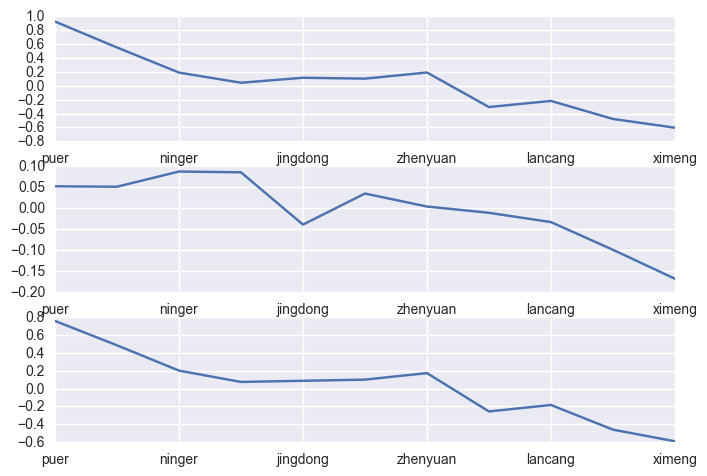

In [1566]:
plt.subplot(3, 1, 1)
rough_mean_sc.loc['笔试',:].plot()   # I want the 3 plots show all ticks on x-axis!

plt.subplot(3, 1, 2)
rough_mean_sc.loc['面试',:].plot(x_compat=True) 

plt.subplot(3, 1, 3)
rough_mean_sc.loc['综合成绩',:].plot(x_compat=True) 

光从总成绩一栏看，可以加high_distr和low_distr，low_distr为边四县（江城，澜沧，孟连，西盟）。  
巴特，还是先把市，区县/县所在镇，乡镇，疑似村社四个level划分出来，  
先跑一遍算法，再做error analysis再看是否需要加high_distr，low_distr.  

In [1567]:
test

,准考证号,姓名,性别,民族,毕业院校,学历,学位,岗位代码,招录单位全称,招考人数,笔试,面试,综合成绩,招考岗位排名,是否录用,年份
86,51274102427,姜琼秀,女,哈尼族,NaN,大学本科,NaN,0822098099,墨江县团田镇（村社区干部）,NaN,155.8,86.43,69.18,1,是,2014
87,11270104428,陈映霞,女,汉族,西双版纳职业技术学院,大学专科,无学位,0821001015,宁洱哈尼族彝族自治县黎明乡人民政府,1,166,88.22,71.78,1,是,2014
88,11360606621,刘婷春,女,汉族,云南大学滇池学院,大学本科,学士,0821001015,宁洱哈尼族彝族自治县黎明乡人民政府,NaN,140,81.78,64.22,2,否,2014
89,11270902315,王旭,男,哈尼族,云南农业大学,大学本科,学士,0827001002,孟连县富岩镇人民政府,1,150,80.48,65.24,1,是,2014
109,11270202312,普晓璐,女,汉族,云南科技信息职业学院,大学专科,无学位,0821001018,宁洱哈尼族彝族自治县梅子镇财政所,NaN,124.5,86.84,64.17,2,是,2014
110,11270203902,彭之春,女,彝族,云南经济管理职业学院,大学专科,无学位,0821001018,宁洱哈尼族彝族自治县梅子镇财政所,NaN,123.5,84.14,62.65,3,否,2014
261,11270700906,林洁,女,汉族,云南大学滇池学院,大学本科,学士,0826996001,普洱市江城县地方税务局,1,138.5,85.97,66.07,1,是,2014
262,11270700925,刀蓉,女,傣族,云南大学滇池学院,大学本科,学士,0826996001,普洱市江城县地方税务局,NaN,134.5,83.72,64.28,2,否,2014
357,51274102312,李万波,男,哈尼族,NaN,大学专科,NaN,0821098097,宁洱县（村社区干部）,NaN,140.3,83.25,65.01,2,否,2014
358,51274102210,段波,男,汉族,NaN,大学专科,NaN,0821098097,宁洱县（村社区干部）,NaN,140.3,81.34,64.05,3,否,2014
